In [1]:
from io import StringIO

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
from copy import copy


def plot(dataframes, labels, value_name, title, initial=None, from_scratch=None, ylim=None, xlim=None, xaxis=None, xaxis_name=None, no_time=False, legend_loc='lower right'):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=100)

    if ylim:
        plt.ylim(ylim)
                
    if initial is not None:
        plt.hlines(initial, 0, 1, linestyle=':', label='initial')

    if from_scratch is not None:
        plt.hlines(from_scratch, 0, 1, color='r', linestyle='--', label='from scratch')

    # main loop
    for df, label in zip(dataframes, labels):
        values = df[value_name]
        s = 1
        if 'degradation' in value_name:
            s = -1

        _xaxis = df[xaxis] if xaxis is not None else df.old_data_amount  
        ax.plot(_xaxis, s * df[value_name], label=label)
        
        std_name = f'{value_name}_std'
        if std_name in df:
            low = df[value_name] - df[std_name]
            high = df[value_name] + df[std_name]
            ax.fill_between(_xaxis, low, high, alpha=0.15)

    if not no_time:
        # set background colors
        green = "#0F9D58"
        yellow = "#F4B400"
        red = "#DB4437"
        for i, c in zip(range(0, 10, 2), [green, yellow, yellow, yellow, red]):
            s = i / 10.
            e = (i + 2) / 10.
            ax.axvspan(s, e, ymax=1, facecolor=c, alpha=0.05)

        secax = ax.secondary_xaxis('top')
        secax.set_xlabel(xaxis_name or 'Old data amount')

        if xlim is None or xlim[1] > 0.5:
            plt.xticks([0.2, 0.4, 0.8, 1.0], ['10 mins', '20 mins', '40 mins', '60 mins'])
        else:
            plt.xticks([0.1, 0.2, 0.4, 0.8, 1.0], ['5 mins', '10 mins', '20 mins', '40 mins', '60 mins'])

        plt.xlabel('Training time')
    else:
        plt.xlabel(xaxis_name or 'Old data amount')


    plt.xlim(xlim or (0, 1))
    plt.ylabel(title)
    if legend_loc is not None:
        plt.legend(loc=legend_loc)
    ax.grid()
#     plt.title(title)
    plt.show()

# NAME_EVENT 95

In [3]:
# report: https://app.wandb.ai/guitaricet/new_semantic_parsing/reports/Finetuning-Aug-14---VmlldzoyMDc0MDY

baseline_csv = """
Name	old_data_amount	relative_improvement	old_data_sampling_method	eval_exact_match	relative_degradation	cls/eval_NAME_EVENT_tree_path_f1
summer-bush-3142 (static)	0	1.81449E-03	merge_subset	7.65127E-01	-1.84092E-02	6.35984E-01
astral-shape-3144 (static)	0.01	0.02	merge_subset	7.96504E-01	-8.42822E-03	6.32042E-01
true-plant-3147 (static)	0.05	2.06529E-02	merge_subset	8.09502E-01	-4.19988E-04	7.45274E-01
trim-sea-3150 (static)	0.1	2.74297E-02	merge_subset	8.13313E-01	-3.61022E-04	7.50146E-01
fanciful-blaze-3153 (static)	0.15	2.86469E-02	merge_subset	8.12864E-01	-3.35906E-04	7.82308E-01
true-bush-3156 (static)	0.2	2.10995E-02	merge_subset	8.16002E-01	-5.77407E-04	7.91604E-01
twilight-paper-3160 (static)	0.5	2.34974E-02	merge_subset	8.18243E-01	-1.78661E-04	8.32356E-01
vague-vortex-3163 (static)	1	0	merge_subset	8.20484E-01	0	8.36152E-01
"""

dynamic_sampling_csv = """
Name	old_data_amount	relative_improvement	old_data_sampling_method	eval_exact_match	relative_degradation	cls/eval_NAME_EVENT_tree_path_f1
warm-rain-3483 (dynamic)	0.01	2.63485E-02	sample	8.05917E-01	-3.30111E-03	7.17136E-01
wild-frost-3487 (dynamic)	0.05	2.53137E-02	sample	8.20036E-01	-5.27164E-04	7.69876E-01
usual-dew-3491 (dynamic)	0.1	3.35035E-02	sample	8.19139E-01	-1.309E-04	7.90383E-01
faithful-snowflake-3495 (dynamic)	0.15	5.90887E-03	sample	8.21156E-01	-7.69231E-05	8.37038E-01
treasured-moon-3500 (dynamic)	0.2	1.77619E-02	sample	8.20036E-01	-5.01353E-04	7.98913E-01
fallen-energy-3505 (dynamic)	0.5	3.66594E-03	sample	8.18243E-01	-1.48678E-04	8.51832E-01
kind-cloud-3510 (dynamic)	1	0	sample	8.20484E-01	0	8.36152E-01
"""

# report https://app.wandb.ai/guitaricet/new_semantic_parsing/reports/Regularization-Aug-11---VmlldzoyMDI2NzU

l2_move_norm_csv = """
Name	old_data_amount	relative_improvement	move_norm	cls/eval_NAME_EVENT_tree_path_f1	absolute_improvement	relative_degradation	eval_exact_match	absolute_degradation
dauntless-pine-3335 (NAME_EVENT)	0.2	2.10513E-02	0.01	7.48512E-01	0.8027	-4.47481E-04	8.14657E-01	-0.1534
upbeat-breeze-3331 (NAME_EVENT)	0.2	2.41245E-02	1	8.03682E-01	0.9339	-4.26928E-05	8.2026E-01	-0.2999
classic-hill-3327 (NAME_EVENT)	0.2	2.10177E-02	0	7.46388E-01	0.7875	-4.41961E-04	8.14881E-01	-0.153
flowing-glitter-3323 (NAME_EVENT)	0.2	2.09303E-02	0.1	7.93067E-01	0.7922	-2.01452E-04	8.15106E-01	-0.4381
firm-flower-3319 (NAME_EVENT)	0.05	2.66396E-02	0.01	7.11791E-01	1.3837	-2.54574E-04	8.08382E-01	-0.3217
dry-frost-3315 (NAME_EVENT)	0.05	0	1	7.49372E-01	0	0	8.12416E-01	0
proud-sun-3309 (NAME_EVENT)	0.05	2.65147E-02	0	7.11799E-01	1.366	-2.91203E-04	8.07486E-01	-0.3243
glorious-sun-3304 (NAME_EVENT)	0.05	2.08861E-02	0.1	7.47963E-01	0.7429	-6.44013E-04	8.12192E-01	-0.5754
honest-shadow-3298 (NAME_EVENT)	0.1	2.11418E-02	0.01	7.67372E-01	0.8732	-2.74767E-04	8.12864E-01	-0.4447
sunny-moon-3290 (NAME_EVENT)	0.1	7.30112E-04	1	7.33292E-01	0.184	-2.7975E-04	8.13088E-01	-0.3503
electric-music-3283 (NAME_EVENT)	0.1	2.1013E-02	0	7.58518E-01	0.8212	-7.15356E-04	8.12192E-01	-0.6644
quiet-bird-3275 (NAME_EVENT)	0.1	2.2615E-02	0.1	7.90574E-01	0.9823	-6.03558E-04	8.13537E-01	-0.8141
"""

freeze_csv = """
Name	old_data_amount	relative_improvement	freeze_encoder	freeze_decoder	freeze_head	absolute_degradation	eval_exact_match	relative_degradation	cls/eval_NAME_EVENT_tree_path_f1	absolute_improvement
decent-flower-3313 (NAME_EVENT)	0.05	2.07204E-02	0	None	None	-0.116	8.09503E-01	-9.20828E-04	7.35496E-01	0.6986
ancient-wave-3310 (NAME_EVENT)	0.05	7.51251E-03	0	0	None	-0.5117	8.0771E-01	-2.99179E-03	7.2666E-01	0.9634
swept-firebrand-3307 (NAME_EVENT)	0.05	2.75126E-02	None	None	None	-0.211	8.09054E-01	-8.83711E-04	7.44597E-01	1.3119
wandering-smoke-3305 (NAME_EVENT)	0.05	2.82557E-02	0	None	0	-0.1744	8.10175E-01	-1.0356E-03	7.26772E-01	1.4776
visionary-planet-3302 (NAME_EVENT)	0.01	1.24132E-04	0	None	None	-0.9816	7.90005E-01	-9.11222E-03	6.22869E-01	0.0129
dandy-mountain-3299 (NAME_EVENT)	0.01	0	0	0	None	-2.6104	7.87315E-01	-1.11163E-02	5.83538E-01	0
young-gorge-3294 (NAME_EVENT)	0.01	0	None	None	None	-1.428	7.94711E-01	-9.20509E-03	6.34996E-01	0
vibrant-durian-3292 (NAME_EVENT)	0.01	4.41528E-03	0	None	0	-1.4384	7.91573E-01	-1.11537E-02	6.33666E-01	0.287
olive-wood-3289 (NAME_EVENT)	0.1	2.82487E-02	0	None	None	-0.2021	8.14657E-01	-4.16349E-04	7.72835E-01	1.4732
morning-frog-3286 (NAME_EVENT)	0.1	2.09901E-02	0	0	None	-0.2619	8.13313E-01	-5.32141E-04	7.48532E-01	0.9442
curious-tree-3282 (NAME_EVENT)	0.1	1.24686E-03	None	None	None	-0.1277	8.14209E-01	-4.19189E-04	7.85869E-01	0.3959
soft-thunder-3278 (NAME_EVENT)	0.1	1.50553E-02	0	None	0	-0.2657	8.13761E-01	-7.21962E-04	7.60754E-01	0.4105
"""

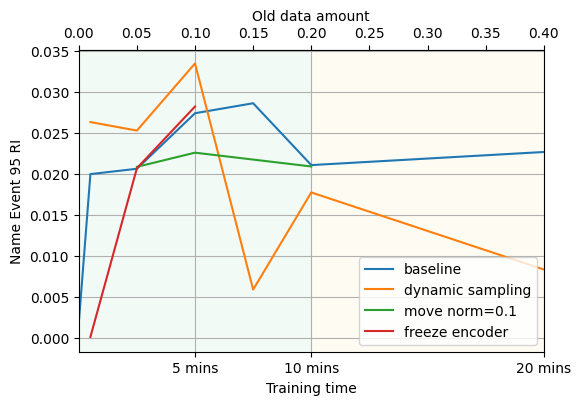

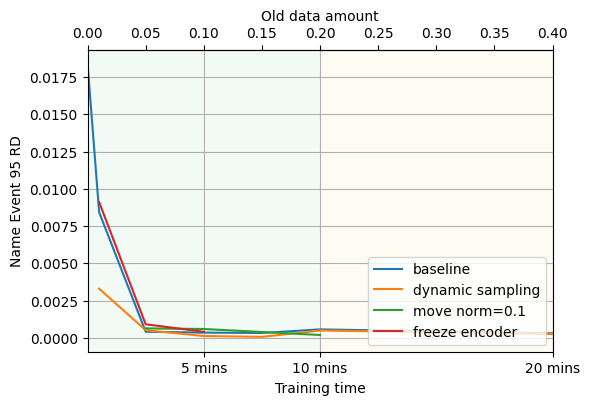

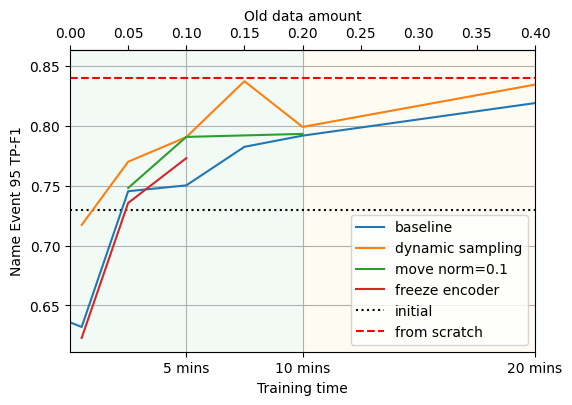

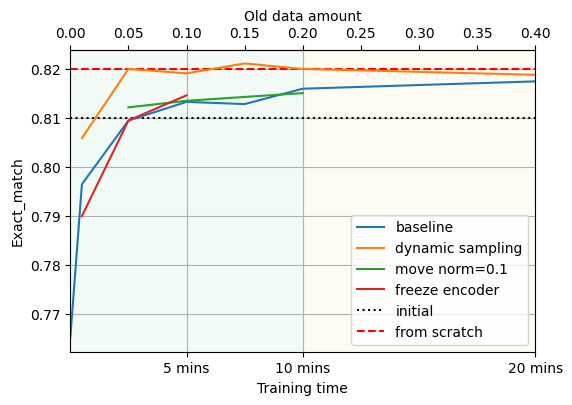

In [4]:
finetune_baseline = pd.read_table(StringIO(baseline_csv)).sort_values("old_data_amount")

dynamic_sampling = pd.read_table(StringIO(dynamic_sampling_csv)).sort_values("old_data_amount")

move_norm_01 = pd.read_table(StringIO(l2_move_norm_csv)).sort_values("old_data_amount")
move_norm_01 = move_norm_01[move_norm_01.move_norm == 0.1]

freeze = pd.read_table(StringIO(freeze_csv)).sort_values("old_data_amount")
freeze = freeze[(freeze.freeze_encoder == "0") & (freeze.freeze_decoder == "None") & (freeze.freeze_head == "None")]

dataframes = [finetune_baseline, dynamic_sampling, move_norm_01, freeze]
labels = ["baseline", "dynamic sampling", "move norm=0.1", "freeze encoder"]

plot(dataframes, labels, "relative_improvement", "Name Event 95 RI", xlim=(0, 0.4))
plot(dataframes, labels, "relative_degradation", "Name Event 95 RD", xlim=(0, 0.4))
plot(dataframes, labels, "cls/eval_NAME_EVENT_tree_path_f1", "Name Event 95 TP-F1", initial=0.73, from_scratch=0.84, xlim=(0, 0.4))
plot(dataframes, labels, "eval_exact_match", "Exact_match", initial=0.81, from_scratch=0.82, xlim=(0, 0.4))

# Path 99

In [67]:
path_99_csv = '''
"Name","old_data_amount","relative_improvement","freeze_encoder","tags","move_norm","_wandb","n_negative_outliers","eval_exact_match","n_positive_outliers","cls/eval_PATH_tree_path_f1","relative_degradation","eval_exact_match_std","cls/eval_PATH_tree_path_f1_std"
"worthy-grass-3933 (baseline)","1","0.4089768121335026","None","[""finetune"",""path_99_Aug19_bert_run_baseline""]","None","","1","0.8231734308073004","23","0.6669097188612698","-0.00008237247458375146","0.0022390300923080695","0.01894788159034069"
"upbeat-sponge-3929 (baseline)","0.7","0.4050011263622404","None","[""finetune"",""path_99_Aug19_bert_run_baseline""]","None","","2","0.818467171622012","20","0.6345360336750203","-0.00006978751624100543","0.0029142864591323436","0.008367072233871165"
"serene-feather-3925 (baseline)","0.5","0.41789593911030737","None","[""finetune"",""path_99_Aug19_bert_run_baseline""]","None","","4","0.816674234716308","14","0.6336539702526485","-0.0004689408325797587","0.0018360704071937223","0.008690454330523536"
"volcanic-morning-3923 (baseline)","0.3","0.3829924200539264","None","[""finetune"",""path_99_Aug19_bert_run_baseline""]","None","","5","0.8195876512039794","18","0.6007143567359632","-0.0005166401972568723","0.003241038163092043","0.0047880053448576135"
"eager-surf-3919 (baseline)","0.2","0.3611285032934759","None","[""finetune"",""path_99_Aug19_bert_run_baseline""]","None","","4","0.8160020286141363","12","0.5868793923352977","-0.0005007422065277036","0.0017413453677061306","0.013519536813895392"
"sage-wave-3915 (baseline)","0.15","0.35979936018140396","None","[""finetune"",""path_99_Aug19_bert_run_baseline""]","None","","1","0.8177949969225358","15","0.5932021758784762","-0.00004615384615384615","0.002819403490551121","0.012718435254448565"
"fancy-sound-3910 (baseline)","0.1","0.31752591393139146","None","[""finetune"",""path_99_Aug19_bert_run_baseline""]","None","","5","0.816674234716308","13","0.5667547150821741","-0.0003742483605577701","0.002665704748169145","0.009027910461945524"
"different-dragon-3905 (baseline)","0.05","0.3482625649692702","None","[""finetune"",""path_99_Aug19_bert_run_baseline""]","None","","8","0.8112955496099785","7","0.5514628468896223","-0.0007361991619334387","0.0024710850252106344","0.009705700477542836"
"earthy-violet-3901 (baseline)","0.01","0.3582726611749777","None","[""finetune"",""path_99_Aug19_bert_run_baseline""]","None","","14","0.7857463164638052","5","0.4583261599093134","-0.0054767990223562185","0.002397410631450395","0.012059744610791833"
"true-microwave-3899 (baseline)","0","0.29532510921181593","None","[""finetune"",""path_99_Aug19_bert_run_baseline""]","None","","20","0.716943544233837","4","0.28247088644426566","-0.02487534276788147","0.003257669611942154","0.012311770311630678"
"astral-hill-3986 (move norm)","1","0.3819566852800854","None","[""finetune"",""path_99_Aug19_bert_run_move_norm""]","0.1","","1","0.8200357990729923","20","0.618624731479077","-0.000057416340822826986","0.001817318099125296","0.029783828407652473"
"earnest-sponge-3985 (move norm)","0.7","0.41815393781876065","None","[""finetune"",""path_99_Aug19_bert_run_move_norm""]","0.1","","2","0.8195877140093705","17","0.612225820614278","-0.0000923076923076923","0.0016521741220217217","0.00945222789626005"
"stoic-sun-3983 (move norm)","0.5","0.4196635357610952","None","[""finetune"",""path_99_Aug19_bert_run_move_norm""]","0.1","","4","0.8168983243521624","13","0.6271250347261745","-0.0006314834579747968","0.002484671187669379","0.011799509148355336"
"denim-plant-3981 (move norm)","0.3","0.4356922214975754","None","[""finetune"",""path_99_Aug19_bert_run_move_norm""]","0.1","","1","0.8195877140093705","19","0.6446250777640039","-0.00002382343337386864","0.0015941670900859969","0.009205725935964384"
"driven-thunder-3979 (move norm)","0.2","0.3921005371249004","None","[""finetune"",""path_99_Aug19_bert_run_move_norm""]","0.1","","4","0.8168984499629449","13","0.599587211010735","-0.0002081267666170349","0.0024113010704354294","0.009187216864643154"
"grateful-fog-3976 (move norm)","0.15","0.38034852202419","None","[""finetune"",""path_99_Aug19_bert_run_move_norm""]","0.1","","2","0.8171226338068859","16","0.5973022312373225","-0.00004249296383532839","0.0016550373923608505","0.005286214731452037"
"polar-tree-3974 (move norm)","0.1","0.38503395037198374","None","[""finetune"",""path_99_Aug19_bert_run_move_norm""]","0.1","","3","0.8144331813442867","16","0.5757735234251766","-0.0001702179442245577","0.0025691068158018625","0.01141242187039656"
"woven-sponge-3972 (move norm)","0.05","0.3624009709504823","None","[""finetune"",""path_99_Aug19_bert_run_move_norm""]","0.1","","8","0.8130885179183782","9","0.5670702911177634","-0.000767445755769673","0.0029313752636679","0.00769253241916831"
"desert-durian-3970 (move norm)","0.01","0.3369685168008895","None","[""finetune"",""path_99_Aug19_bert_run_move_norm""]","0.1","","14","0.7902285802213262","7","0.4640042024827391","-0.004104864143022013","0.002313626980114708","0.010450256182242162"
"dark-wave-3967 (move norm)","0","0.2827202925621297","None","[""finetune"",""path_99_Aug19_bert_run_move_norm""]","0.1","","19","0.7198570549295951","4","0.27829451934721644","-0.024415436115954443","0.0036749016984263414","0.010378089475630984"
"dainty-pine-3963 (dynamic sampling)","1","0.4089768121335026","None","[""finetune"",""path_99_Aug19_bert_run_sample""]","None","","1","0.8231734308073004","23","0.6669097188612698","-0.00008237247458375146","0.0022390300923080695","0.01894788159034069"
"jolly-pyramid-3957 (dynamic sampling)","0.7","0.4573266458958006","None","[""finetune"",""path_99_Aug19_bert_run_sample""]","None","","1","0.8233977402620241","18","0.6603823165229634","-0.00003370226895406751","0.0018304611918279969","0.011508335465266108"
"lyric-glade-3954 (dynamic sampling)","0.5","0.4545438436954288","None","[""finetune"",""path_99_Aug19_bert_run_sample""]","None","","1","0.8204837899285276","14","0.6538574226689414","-0.00004615384615384615","0.0026205383390111017","0.013957772708167136"
"floral-music-3950 (dynamic sampling)","0.3","0.4377929623094582","None","[""finetune"",""path_99_Aug19_bert_run_sample""]","None","","1","0.8200354222406452","16","0.6312316930504941","-0.00002257885998893192","0.0027596651279405736","0.015426718044129897"
"apricot-snowball-3948 (dynamic sampling)","0.2","0.3838646154869562","None","[""finetune"",""path_99_Aug19_bert_run_sample""]","None","","5","0.8218290814083481","12","0.6062921085733671","-0.0004044534049844785","0.0025398627836686173","0.014651703284489313"
"pretty-meadow-3945 (dynamic sampling)","0.15","0.42266779887711775","None","[""finetune"",""path_99_Aug19_bert_run_sample""]","None","","4","0.8209322518244966","18","0.620886039456175","-0.0002865770002577789","0.0028680977925235585","0.021102708927763295"
"cosmic-bush-3943 (dynamic sampling)","0.1","0.36954637622567954","None","[""finetune"",""path_99_Aug19_bert_run_sample""]","None","","3","0.8211569381115675","11","0.6063327560246088","-0.0002231365987348505","0.004874048380538807","0.013310048532183504"
"trim-blaze-3941 (dynamic sampling)","0.05","0.4108316383334611","None","[""finetune"",""path_99_Aug19_bert_run_sample""]","None","","2","0.8186912298551707","16","0.6164684716688354","-0.00013187738112227686","0.002093596346941733","0.009445315077732032"
"neat-morning-3938 (dynamic sampling)","0.01","0.359478884793078","None","[""finetune"",""path_99_Aug19_bert_run_sample""]","None","","7","0.8036754028965847","8","0.5119954449147462","-0.0005729477789156379","0.0010227587142443114","0.02808039738311596"
"rose-fire-3936 (dynamic sampling)","0","0.29532510921181593","None","[""finetune"",""path_99_Aug19_bert_run_sample""]","None","","20","0.716943544233837","4","0.28247088644426566","-0.02487534276788147","0.003257669611942154","0.012311770311630678"
"sweet-silence-4025 (freeze encoder)","1","0.46342809285090786","0","[""finetune"",""path_99_Aug19_bert_run_freeze""]","None","","1","0.8225010676916507","19","0.6598013409289851","-0.000050573167839354894","0.0024557312654849353","0.01594283238158078"
"rare-snowflake-4018 (freeze encoder)","0.7","0.4315884037328815","0","[""finetune"",""path_99_Aug19_bert_run_freeze""]","None","","2","0.8186911670497796","17","0.6212107532742361","-0.00007569537773586585","0.0014433799146796834","0.003063659677930398"
"hearty-moon-4008 (freeze encoder)","0.3","0.4850507576920829","0","[""finetune"",""path_99_Aug19_bert_run_freeze""]","None","","1","0.8173464094157843","17","0.6294498365152243","-0.00003054815558571143","0.0017064957268037334","0.0067744738571502774"
"spring-bird-4006 (freeze encoder)","0.2","0.43236775553921025","0","[""finetune"",""path_99_Aug19_bert_run_freeze""]","None","","1","0.8180190551556945","14","0.6441239119453678","-0.00013846153846153847","0.002529812350189527","0.01627359585438132"
"deep-dust-3999 (freeze encoder)","0.15","0.3989723623822516","0","[""finetune"",""path_99_Aug19_bert_run_freeze""]","None","","5","0.8146573023828365","12","0.5718474081491283","-0.00026772387327196986","0.002617096378225874","0.00947962287004747"
"treasured-waterfall-3996 (freeze encoder)","0.1","0.4411257958198475","0","[""finetune"",""path_99_Aug19_bert_run_freeze""]","None","","3","0.812416091997337","16","0.5911838785866295","-0.0001498156607081294","0.0036347315330967542","0.018373829778381943"
"helpful-donkey-3992 (freeze encoder)","0.05","0.3964963843769149","0","[""finetune"",""path_99_Aug19_bert_run_freeze""]","None","","6","0.8050204117521448","11","0.574604445930647","-0.0003824050933891784","0.002795368259926313","0.012029724449936625"
"amber-disco-3990 (freeze encoder)","0.01","0.34809637840211566","0","[""finetune"",""path_99_Aug19_bert_run_freeze""]","None","","19","0.783057178028162","4","0.438722982287389","-0.006750677648521722","0.0033569860526064133","0.00956190059455206"
"neat-music-3987 (freeze encoder)","0","0.3044025175918937","0","[""finetune"",""path_99_Aug19_bert_run_freeze""]","None","","25","0.6851188906055696","5","0.25746057512446796","-0.03578967862214255","0.0024716388685916903","0.013642334087555764"
"sweet-silence-4025 (freeze)","1","0.46342809285090786","0","[""finetune"",""path_99_Aug19_bert_run_freeze""]","None","","1","0.8225010676916507","19","0.6598013409289851","-0.000050573167839354894","0.0024557312654849353","0.01594283238158078"
"rare-snowflake-4018 (freeze)","0.7","0.4315884037328815","0","[""finetune"",""path_99_Aug19_bert_run_freeze""]","None","","2","0.8186911670497796","17","0.6212107532742361","-0.00007569537773586585","0.0014433799146796834","0.003063659677930398"
"hearty-moon-4008 (freeze)","0.3","0.4850507576920829","0","[""finetune"",""path_99_Aug19_bert_run_freeze""]","None","","1","0.8173464094157843","17","0.6294498365152243","-0.00003054815558571143","0.0017064957268037334","0.0067744738571502774"
"spring-bird-4006 (freeze)","0.2","0.43236775553921025","0","[""finetune"",""path_99_Aug19_bert_run_freeze""]","None","","1","0.8180190551556945","14","0.6441239119453678","-0.00013846153846153847","0.002529812350189527","0.01627359585438132"
"deep-dust-3999 (freeze)","0.15","0.3989723623822516","0","[""finetune"",""path_99_Aug19_bert_run_freeze""]","None","","5","0.8146573023828365","12","0.5718474081491283","-0.00026772387327196986","0.002617096378225874","0.00947962287004747"
"treasured-waterfall-3996 (freeze)","0.1","0.4411257958198475","0","[""finetune"",""path_99_Aug19_bert_run_freeze""]","None","","3","0.812416091997337","16","0.5911838785866295","-0.0001498156607081294","0.0036347315330967542","0.018373829778381943"
"helpful-donkey-3992 (freeze)","0.05","0.3964963843769149","0","[""finetune"",""path_99_Aug19_bert_run_freeze""]","None","","6","0.8050204117521448","11","0.574604445930647","-0.0003824050933891784","0.002795368259926313","0.012029724449936625"
"amber-disco-3990 (freeze)","0.01","0.34809637840211566","0","[""finetune"",""path_99_Aug19_bert_run_freeze""]","None","","19","0.783057178028162","4","0.438722982287389","-0.006750677648521722","0.0033569860526064133","0.00956190059455206"
"neat-music-3987 (freeze)","0","0.3044025175918937","0","[""finetune"",""path_99_Aug19_bert_run_freeze""]","None","","25","0.6851188906055696","5","0.25746057512446796","-0.03578967862214255","0.0024716388685916903","0.013642334087555764"
"wandering-totem-4077 (best)","1","0.3959545266972418","0","[""finetune"",""path_99_Aug19_bert_run_best""]","0.1","","1","0.8191393777241839","15","0.6064625802645424","-0.00008106861650127973","0.0024598704993703466","0.015173778970375033"
"likely-blaze-4071 (best)","0.7","0.3890145946834757","0","[""finetune"",""path_99_Aug19_bert_run_best""]","0.1","","1","0.8184676112597504","17","0.5836486022956824","-0.000021196932563839016","0.0026849488679010296","0.016952062185168797"
"cosmic-mountain-4067 (best)","0.5","0.387851799334024","0","[""finetune"",""path_99_Aug19_bert_run_best""]","0.1","","2","0.8182435844292874","20","0.565874715162223","-0.00006288463994675802","0.0045792197350176","0.016638197363487272"
"celestial-jazz-4064 (best)","0.3","0.40786487154392626","0","[""finetune"",""path_99_Aug19_bert_run_best""]","0.1","","3","0.8177944316740149","17","0.5771017913000946","-0.00021977366841479583","0.0028556670801470844","0.014432491938419287"
"swept-brook-4056 (best)","0.2","0.4411810862890981","0","[""finetune"",""path_99_Aug19_bert_run_best""]","0.1","","2","0.8166742033136124","23","0.6212959308921846","-0.00006261470315830409","0.004997551511633349","0.012125906052058743"
"morning-dust-4052 (best)","0.15","0.4430173424449153","0","[""finetune"",""path_99_Aug19_bert_run_best""]","0.1","","4","0.8166743289243948","16","0.611389772622742","-0.00023620780890256288","0.0016649885425307988","0.014074343195926734"
"devout-sun-4048 (best)","0.1","0.4101476073530927","0","[""finetune"",""path_99_Aug19_bert_run_best""]","0.1","","5","0.813984593837535","11","0.5770041534051297","-0.0005312108638508137","0.0009528957251077868","0.009975739860289353"
"spring-thunder-4042 (best)","0.05","0.43225444292594833","0","[""finetune"",""path_99_Aug19_bert_run_best""]","0.1","","5","0.8117437288816871","12","0.5749024693212017","-0.0004788410078320304","0.004570406611604442","0.01465819171313954"
"upbeat-voice-4038 (best)","0.01","0.37118530718905174","0","[""finetune"",""path_99_Aug19_bert_run_best""]","0.1","","11","0.7900041765585157","6","0.4870295031227505","-0.004103110729058984","0.003308034863606202","0.020960165345784744"
"sweet-wildflower-4036 (best)","0","0.31818806817034173","0","[""finetune"",""path_99_Aug19_bert_run_best""]","0.1","","24","0.6934110550049616","5","0.264351210929277","-0.03340736070257223","0.0027151652767143306","0.012679265932543874"'''

path_99_move_norm_csv = '''
"Name","old_data_amount","relative_improvement","move_norm","tags","old_data_sampling_method","_wandb","relative_degradation_0","cls/eval_PATH_tree_path_f1_std","eval_exact_match_std","relative_degradation","eval_exact_match","cls/eval_PATH_tree_path_f1","relative_improvement_0"
"tough-grass-3753 (move norm merge)","0.1","0.3760431141688412","0.1","[""finetune"",""path_99_Aug17_bert_run_move_norm""]","merge_subset","","-0.0006998044373558427","0.008518319719778454","0.00275953017505308","-0.00030965440480959234","0.8097268907563026","0.5877849311132967","0.3777780258309712"
"lucky-frost-3747 (move norm merge)","0.05","0.3026670144064442","0.1","[""finetune"",""path_99_Aug17_bert_run_move_norm""]","merge_subset","","-0.0015103047369099758","0.009752695007202586","0.0023277820903453697","-0.000690952051333466","0.8045720126615669","0.5213166534843348","0.30413281854768204"
"leafy-dream-3744 (move norm merge)","0.01","0.3852182870253074","0.1","[""finetune"",""path_99_Aug17_bert_run_move_norm""]","merge_subset","","-0.0034627360511878726","0.009127202568388584","0.0018110281077611877","-0.0008823598552407739","0.7897803695469219","0.48506267720233814","0.3856035980652287"
"fanciful-wood-3677 (move norm sample)","1","0.4047366782925984","0.1","[""finetune"",""path_99_Aug17_bert_run_move_norm""]","sample","","","0.023656789647313617","0.0029636182767971853","-0.0001956687890251282","0.8195879024255441","0.6241552992535568",""
"true-silence-3670 (move norm sample)","0.7","0.412833396250576","0.1","[""finetune"",""path_99_Aug17_bert_run_move_norm""]","sample","","","0.013953706300364856","0.004031290943361171","-0.0003788885573306437","0.8193635615681251","0.6335706623171842",""
"amber-cosmos-3662 (move norm sample)","0.5","0.42793542381355737","0.1","[""finetune"",""path_99_Aug17_bert_run_move_norm""]","sample","","","0.016863444397297596","0.0036902488444013823","-0.0001819064013912691","0.818018709726043","0.6334016561224303",""
"worldly-lion-3657 (move norm sample)","0.3","0.4031053521113884","0.1","[""finetune"",""path_99_Aug17_bert_run_move_norm""]","sample","","","0.019395492259695283","0.004058805620271892","-0.0006172097676206878","0.8173463152076973","0.620566739883734",""
"giddy-water-3652 (move norm sample)","0.2","0.4413213292128126","0.1","[""finetune"",""path_99_Aug17_bert_run_move_norm""]","sample","","","0.016322804417609114","0.0041905574330090515","-0.00007822850667078409","0.8182429249726797","0.6433205750287216",""
"magic-water-3646 (move norm sample)","0.15","0.3967554075284435","0.1","[""finetune"",""path_99_Aug17_bert_run_move_norm""]","sample","","","0.00963134580870608","0.003759282812258812","-0.0002925963103086273","0.8164501136777581","0.5985974128538902",""
"apricot-glade-3638 (move norm sample)","0.1","0.3789342585196072","0.1","[""finetune"",""path_99_Aug17_bert_run_move_norm""]","sample","","","0.01440841079896769","0.005079734856469627","-0.00010189546209922592","0.8180187725314341","0.5983607382831873",""
"glorious-fire-3634 (move norm sample)","0.05","0.3681461744703784","0.1","[""finetune"",""path_99_Aug17_bert_run_move_norm""]","sample","","","0.014899343701717166","0.003562247443376942","-0.0002523744293955817","0.8124158093730767","0.5624369851097771",""
"electric-brook-3631 (move norm sample)","0.01","0.37928254490842983","0.1","[""finetune"",""path_99_Aug17_bert_run_move_norm""]","sample","","","0.01399040173990151","0.004354000025961459","-0.0002547847611694564","0.8012101028752309","0.5281311134301306",""
"wobbly-plasma-3629 (move norm sample)","0","0.35454822331630764","0.1","[""finetune"",""path_99_Aug17_bert_run_move_norm""]","sample","","","0.015629163279653926","0.0035072381887926887","-0.02226306367352723","0.729045703483187","0.33735975538946794",""
'''

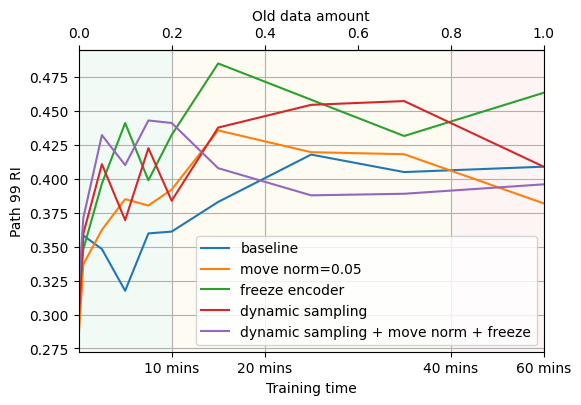

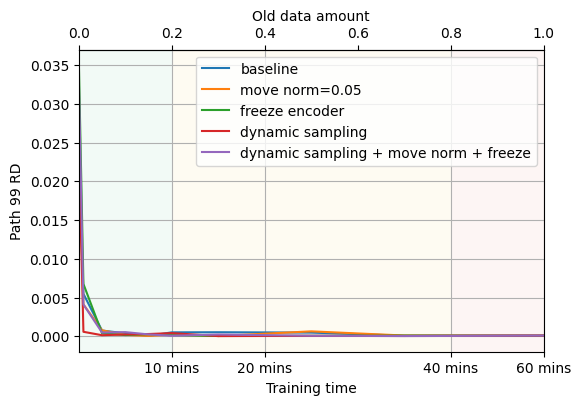

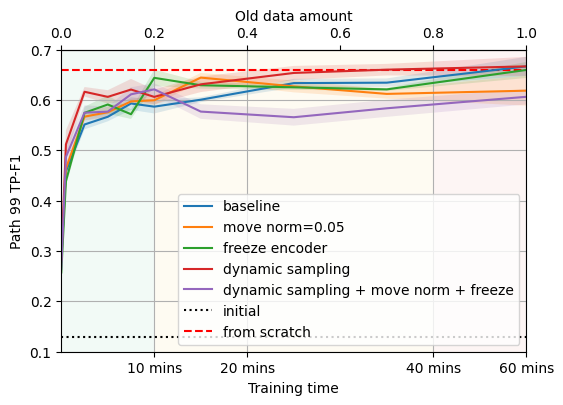

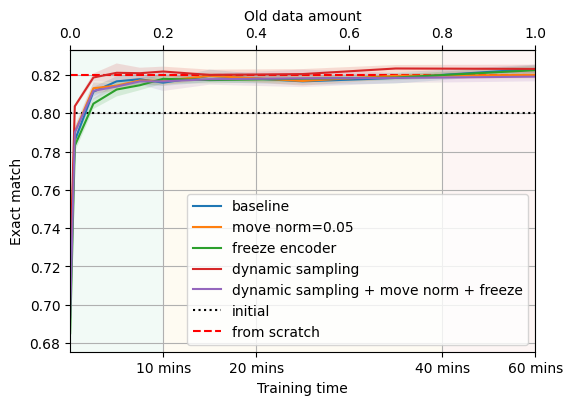

In [75]:
dataframe = pd.read_csv(StringIO(path_99_csv)).sort_values("old_data_amount")

_tag = '["finetune","path_99_Aug19_bert_run_baseline"]'
finetune_baseline = dataframe[dataframe.tags == _tag]

_tag = '["finetune","path_99_Aug19_bert_run_sample"]'
dynamic_sampling = dataframe[dataframe.tags == _tag]

_tag = '["finetune","path_99_Aug19_bert_run_move_norm"]'
move_norm = dataframe[dataframe.tags == _tag]

# _tag = '["finetune","path_90_Aug18_bert_run_average09"]'
# average09 = dataframe[dataframe.tags == _tag]

_tag = '["finetune","path_99_Aug19_bert_run_freeze"]'
freeze = dataframe[dataframe.tags == _tag]
freeze = freeze[(freeze.freeze_encoder == "0")] # & (freeze.freeze_decoder == "None") & (freeze.freeze_head == "None")]

_tag = '["finetune","path_99_Aug19_bert_run_best"]'
combination = dataframe[dataframe.tags == _tag]

# _tag = '["finetune","path_99_Aug19_bert_run_nobert"]'
# nobert = dataframe[dataframe.tags == _tag]

# move norm different run
dataframe2 = pd.read_csv(StringIO(path_99_move_norm_csv)).sort_values("old_data_amount")

move_norm_static = dataframe2[dataframe2.old_data_sampling_method == 'merge_subset']
move_norm_dynamic = dataframe2[dataframe2.old_data_sampling_method == 'sample']


dataframes = [finetune_baseline, move_norm, freeze, dynamic_sampling, combination]
labels = ["baseline", "move norm=0.05", "freeze encoder", "dynamic sampling", "dynamic sampling + move norm + freeze"]

# dataframes = [finetune_baseline, dynamic_sampling, move_norm, move_norm_static, move_norm_dynamic]
# labels = ['baseline', 'dynamic sampling', 'move norm=0.1', 'move norm=0.1 (again)', 'move norm=0.1 + dynamic sampling']

plot(dataframes, labels, "relative_improvement", "Path 99 RI")
plot(dataframes, labels, "relative_degradation", "Path 99 RD", legend_loc='best', ylim=(-0.002, 0.037))
plot(dataframes, labels, "cls/eval_PATH_tree_path_f1", "Path 99 TP-F1", ylim=(0.1, 0.7), initial=0.13, from_scratch=0.66)
plot(dataframes, labels, "eval_exact_match", "Exact match", initial=0.80, from_scratch=0.82)

# PATH 90

In [72]:
path_90_csv = '''
"Name","old_data_amount","relative_improvement","move_norm","tags","freeze_encoder","_wandb","cls/eval_PATH_tree_path_f1","eval_exact_match_std","eval_exact_match","relative_degradation","relative_improvement_0","cls/eval_PATH_tree_path_f1_std"
"hearty-puddle-3839 (dynamic sampling)","1","0.026237815081313814","None","[""finetune"",""path_90_Aug18_bert_run_sample""]","None","","0.6747931215772087","0.0032778972288927248","0.8240699777668915","-0.0000725556774154044","0.02705698322332476","0.02162481604757129"
"olive-firebrand-3833 (dynamic sampling)","0.7","0.03226422107763793","None","[""finetune"",""path_90_Aug18_bert_run_sample""]","None","","0.6199847605358595","0.003056791479035705","0.8202600457223248","-0.0006357072345904401","0.03329597255258138","0.015568618158984686"
"solar-pine-3825 (dynamic sampling)","0.5","0.024062928070138937","None","[""finetune"",""path_90_Aug18_bert_run_sample""]","None","","0.636747076575767","0.002847366749625553","0.8231735564180829","-0.0002211386917931639","0.026452303928958573","0.024151001698679272"
"swift-snowball-3819 (dynamic sampling)","0.3","0.029680636199112834","None","[""finetune"",""path_90_Aug18_bert_run_sample""]","None","","0.6389469949030668","0.0036367863722186343","0.8216043951212771","-0.000022357498616491408","0.031634889425073906","0.009108234533583996"
"dutiful-sky-3816 (dynamic sampling)","0.2","0.023989824481039427","None","[""finetune"",""path_90_Aug18_bert_run_sample""]","None","","0.6642841982706135","0.0036217444207389863","0.8186912926605621","-0.0003054761667286215","0.02584511931424232","0.01406936730716758"
"avid-wind-3811 (dynamic sampling)","0.15","0.038516957798128255","None","[""finetune"",""path_90_Aug18_bert_run_sample""]","None","","0.6673838663148859","0.0024053112562741736","0.8218288301867831","-0.0004693473396301596","0.039186987665632694","0.0185280300776865"
"dry-sun-3806 (dynamic sampling)","0.1","0.009306374197905727","None","[""finetune"",""path_90_Aug18_bert_run_sample""]","None","","0.585718195547124","0.0025646698115606927","0.8218285475625228","-0.00007577414968166909","0.011754074669785314","0.020300742595707588"
"fast-mountain-3800 (dynamic sampling)","0.05","0.030657774572160033","None","[""finetune"",""path_90_Aug18_bert_run_sample""]","None","","0.6057029539704792","0.0018951254512057792","0.8157776877567169","-0.0002872339505919243","0.032874303814280664","0.017452301363430525"
"earthy-shape-3795 (dynamic sampling)","0.01","0.0004887567059073283","None","[""finetune"",""path_90_Aug18_bert_run_sample""]","None","","0.5258584068057046","0.0025629745569716116","0.8021066184321264","-0.005043584907902268","0.0006891346783489063","0.020364470334813336"
"proud-cosmos-3791 (dynamic sampling)","0","0.00021648142796688836","None","[""finetune"",""path_90_Aug18_bert_run_sample""]","None","","0.37433903927652407","0.0014568423198916274","0.7489917536521336","-0.020988502705119556","0.0004724342553667589","0.01371641233777596"
"earnest-dream-3927 (average09)","1","0.026237815081313814","None","[""finetune"",""path_90_Aug18_bert_run_average09""]","None","","0.6747931215772087","0.0032778972288927248","0.8240699777668915","-0.0000725556774154044","0.02705698322332476","0.02162481604757129"
"distinctive-durian-3921 (average09)","0.3","0","None","[""finetune"",""path_90_Aug18_bert_run_average09""]","None","","0.5849362272706957","0.0015152991334947772","0.816001808795267","0","0.004166530946872944","0.014191415462790973"
"deep-sky-3912 (average09)","0.15","0.0005731285467266762","None","[""finetune"",""path_90_Aug18_bert_run_average09""]","None","","0.5371409401178538","0.002157973995564929","0.8110713657660373","-0.0002603661022545611","0.001565080615198602","0.014052788104170034"
"rose-sea-3904 (average09)","0.01","0.00018032804319535444","None","[""finetune"",""path_90_Aug18_bert_run_average09""]","None","","0.49915601023919554","0.0027071230324596496","0.7931420909170843","-0.005830161113002822","0.0006033189400928282","0.017517709434360255"
"good-energy-3866 (average09)","0.7","0.012818709928564835","None","[""finetune"",""path_90_Aug18_bert_run_average09""]","None","","0.625410250169069","0.004195692866102766","0.8231737762369521","-0.00014056098738622887","0.014236689907694302","0.02198673413705394"
"dutiful-night-3860 (average09)","0.5","0.025347154452432873","None","[""finetune"",""path_90_Aug18_bert_run_average09""]","None","","0.6181669377116786","0.0018151063838169987","0.8195877140093705","-0.00020479580168857625","0.02767419434439518","0.006186795471945901"
"eternal-flower-3854 (average09)","0.2","0.0012360646421392463","None","[""finetune"",""path_90_Aug18_bert_run_average09""]","None","","0.5859054899581055","0.0016141177574038722","0.8121919709587871","-0.0009845895514415122","0.0019963054073255924","0.006929863090380031"
"worldly-brook-3848 (average09)","0.1","0.0013114022090106126","None","[""finetune"",""path_90_Aug18_bert_run_average09""]","None","","0.5841256366432099","0.002904574379568778","0.8128641142555677","-0.0012147850903114895","0.001695382122186337","0.010529381977232976"
"dainty-brook-3844 (average09)","0.05","0.0011597743423743191","None","[""finetune"",""path_90_Aug18_bert_run_average09""]","None","","0.5814341560285986","0.002209970365664912","0.8074854919546294","-0.003011871309856572","0.0015305066905277431","0.0128393525790584"
"driven-breeze-3841 (average09)","0","0.00021648142796688836","None","[""finetune"",""path_90_Aug18_bert_run_average09""]","None","","0.37433903927652407","0.0014568423198916274","0.7489917536521336","-0.020988502705119556","0.0004724342553667589","0.01371641233777596"
"earthy-plasma-3832 (baseline)","1","0.026237815081313814","None","[""finetune"",""path_90_Aug18_bert_run_baseline""]","None","","0.6747931215772087","0.0032778972288927248","0.8240699777668915","-0.0000725556774154044","0.02705698322332476","0.02162481604757129"
"chocolate-shadow-3822 (baseline)","0.7","0.012818709928564835","None","[""finetune"",""path_90_Aug18_bert_run_baseline""]","None","","0.625410250169069","0.004195692866102766","0.8231737762369521","-0.00014056098738622887","0.014236689907694302","0.02198673413705394"
"icy-sunset-3817 (baseline)","0.5","0.025347154452432873","None","[""finetune"",""path_90_Aug18_bert_run_baseline""]","None","","0.6181669377116786","0.0018151063838169987","0.8195877140093705","-0.00020479580168857625","0.02767419434439518","0.006186795471945901"
"legendary-mountain-3813 (baseline)","0.3","0","None","[""finetune"",""path_90_Aug18_bert_run_baseline""]","None","","0.5849362272706957","0.0015152991334947772","0.816001808795267","0","0.004166530946872944","0.014191415462790973"
"sandy-fire-3807 (baseline)","0.2","0.0012360646421392463","None","[""finetune"",""path_90_Aug18_bert_run_baseline""]","None","","0.5859054899581055","0.0016141177574038722","0.8121919709587871","-0.0009845895514415122","0.0019963054073255924","0.006929863090380031"
"lemon-hill-3798 (baseline)","0.15","0.0005731285467266762","None","[""finetune"",""path_90_Aug18_bert_run_baseline""]","None","","0.5371409401178538","0.002157973995564929","0.8110713657660373","-0.0002603661022545611","0.001565080615198602","0.014052788104170034"
"fast-field-3794 (baseline)","0.1","0.0013114022090106126","None","[""finetune"",""path_90_Aug18_bert_run_baseline""]","None","","0.5841256366432099","0.002904574379568778","0.8128641142555677","-0.0012147850903114895","0.001695382122186337","0.010529381977232976"
"vocal-eon-3789 (baseline)","0.05","0.0011597743423743191","None","[""finetune"",""path_90_Aug18_bert_run_baseline""]","None","","0.5814341560285986","0.002209970365664912","0.8074854919546294","-0.003011871309856572","0.0015305066905277431","0.0128393525790584"
"dulcet-monkey-3784 (baseline)","0.01","0.00018032804319535444","None","[""finetune"",""path_90_Aug18_bert_run_baseline""]","None","","0.49915601023919554","0.0027071230324596496","0.7931420909170843","-0.005830161113002822","0.0006033189400928282","0.017517709434360255"
"faithful-star-3782 (baseline)","0","0.00021648142796688836","None","[""finetune"",""path_90_Aug18_bert_run_baseline""]","None","","0.37433903927652407","0.0014568423198916274","0.7489917536521336","-0.020988502705119556","0.0004724342553667589","0.01371641233777596"
"denim-wildflower-3882 (move norm)","1","0.026267585551292147","0.05","[""finetune"",""path_90_Aug18_bert_run_move_norm005""]","None","","0.6496191889297402","0.002730910503259659","0.8231736192234742","-0.0003288599162128759","0.027528778329032583","0.027327146954062697"
"lemon-plasma-3880 (move norm)","0.7","0.02510761693762404","0.05","[""finetune"",""path_90_Aug18_bert_run_move_norm005""]","None","","0.6461749051254853","0.002918829351789294","0.8220527942118551","-0.0000793618790768566","0.026394722543714017","0.017677606488782097"
"glad-sunset-3876 (move norm)","0.5","0.02226746106929288","0.05","[""finetune"",""path_90_Aug18_bert_run_move_norm005""]","None","","0.6414620177982467","0.002515276756238535","0.8191396603484442","-0.0001608674054738061","0.023866958555758027","0.020184756584596963"
"vivid-bee-3872 (move norm)","0.3","0.0012983497790763675","0.05","[""finetune"",""path_90_Aug18_bert_run_move_norm005""]","None","","0.5924517571348298","0.001615289546534278","0.8133124505407544","-0.0001494263710812318","0.0025727140607697658","0.012515260087573114"
"wandering-sea-3869 (move norm)","0.2","0.02110571750088856","0.05","[""finetune"",""path_90_Aug18_bert_run_move_norm005""]","None","","0.6106614155394898","0.0023482537010498586","0.8130886121264649","-0.0009539295217994696","0.02157398275570856","0.010696361021916666"
"cool-field-3867 (move norm)","0.15","0.00825484392097619","0.05","[""finetune"",""path_90_Aug18_bert_run_move_norm005""]","None","","0.6073118072921246","0.001680083857055863","0.8144332127469822","-0.0005184943871433716","0.009580559482250384","0.008212483960779497"
"solar-butterfly-3865 (move norm)","0.1","0.00133904633395929","0.05","[""finetune"",""path_90_Aug18_bert_run_move_norm005""]","None","","0.5860414679720655","0.0029319962957037224","0.8126400246197134","-0.0013081021744469842","0.0016727120797657476","0.009606412097178885"
"revived-resonance-3862 (move norm)","0.05","0.0013033590551409751","0.05","[""finetune"",""path_90_Aug18_bert_run_move_norm005""]","None","","0.5752142029997094","0.0019908860813334147","0.8072613709160794","-0.002854012743399339","0.0015760651763626146","0.013115574582578495"
"copper-smoke-3858 (move norm)","0.01","0.00030157441316304716","0.05","[""finetune"",""path_90_Aug18_bert_run_move_norm005""]","None","","0.49774214180773246","0.0029551413958039466","0.7949350592254839","-0.005396236567445527","0.000583228602830331","0.016358249575532127"
"dulcet-universe-3852 (move norm)","0","0.00003781509781049149","0.05","[""finetune"",""path_90_Aug18_bert_run_move_norm005""]","None","","0.36636174123397897","0.0014342705632693403","0.750560538116592","-0.02074773580190287","0.0002961299937938529","0.017649388249513592"
"fancy-wave-3881 (average05)","0.7","0.012818709928564835","None","[""finetune"",""path_90_Aug18_bert_run_average05""]","None","","0.625410250169069","0.004195692866102766","0.8231737762369521","-0.00014056098738622887","0.014236689907694302","0.02198673413705394"
"solar-valley-3879 (average05)","0.5","0.025347154452432873","None","[""finetune"",""path_90_Aug18_bert_run_average05""]","None","","0.6181669377116786","0.0018151063838169987","0.8195877140093705","-0.00020479580168857625","0.02767419434439518","0.006186795471945901"
"robust-grass-3877 (average05)","0.2","0.0012360646421392463","None","[""finetune"",""path_90_Aug18_bert_run_average05""]","None","","0.5859054899581055","0.0016141177574038722","0.8121919709587871","-0.0009845895514415122","0.0019963054073255924","0.006929863090380031"
"rural-sound-3875 (average05)","0.1","0.0013114022090106126","None","[""finetune"",""path_90_Aug18_bert_run_average05""]","None","","0.5841256366432099","0.002904574379568778","0.8128641142555677","-0.0012147850903114895","0.001695382122186337","0.010529381977232976"
"usual-flower-3873 (average05)","0.05","0.0011597743423743191","None","[""finetune"",""path_90_Aug18_bert_run_average05""]","None","","0.5814341560285986","0.002209970365664912","0.8074854919546294","-0.003011871309856572","0.0015305066905277431","0.0128393525790584"
"trim-oath-3871 (average05)","0","0.00021648142796688836","None","[""finetune"",""path_90_Aug18_bert_run_average05""]","None","","0.37433903927652407","0.0014568423198916274","0.7489917536521336","-0.020988502705119556","0.0004724342553667589","0.01371641233777596"
"celestial-bird-3984 (sample + freeze + move norm)","0.01","","None","[""finetune"",""path_90_Aug18_bert_run_best""]","None","","","","","","",""
"firm-moon-3978 (sample + freeze + move norm)","1","0.022360214981275557","0.05","[""finetune"",""path_90_Aug18_bert_run_best""]","0","","0.6339538524678037","0.003643835140069199","0.8195876198012837","-0.0002835982718224105","0.02436938749503194","0.022269378200842432"
"brisk-jazz-3969 (sample + freeze + move norm)","0.7","0.03032674882581909","0.05","[""finetune"",""path_90_Aug18_bert_run_best""]","0","","0.611614562796478","0.0037690072359519754","0.8195877454120662","-0.000134842424495143","0.03235734608949016","0.01623393154288121"
"bumbling-water-3964 (sample + freeze + move norm)","0.5","0.027209958386176018","0.05","[""finetune"",""path_90_Aug18_bert_run_best""]","0","","0.6585712486417472","0.003192772537733049","0.8191393777241839","-0.0003679092848216271","0.02878649465713809","0.01420885370147035"
"swept-fire-3958 (sample + freeze + move norm)","0.3","0.00981981050036356","0.05","[""finetune"",""path_90_Aug18_bert_run_best""]","0","","0.6361684482344165","0.002372994045347034","0.8177948085063622","-0.00004505015175588988","0.012130287010738802","0.012076820839799144"
"astral-lake-3952 (sample + freeze + move norm)","0.2","0.02863799427640587","0.05","[""finetune"",""path_90_Aug18_bert_run_best""]","0","","0.6290024519081608","0.003138160259302491","0.8177947771036665","-0.0002076584402183996","0.03028288891284513","0.013859809688466644"
"vague-music-3949 (sample + freeze + move norm)","0.15","0.0015008879542907476","0.05","[""finetune"",""path_90_Aug18_bert_run_best""]","0","","0.6417047815729406","0.0027994346046671687","0.8160019344060494","-0.00038451465301195465","0.002641362669830101","0.017052371990471504"
"resilient-music-3947 (sample + freeze + move norm)","0.1","0.029041031352460556","0.05","[""finetune"",""path_90_Aug18_bert_run_best""]","0","","0.6210739936581151","0.0028427791407558047","0.8151055444599364","-0.0001928890383599616","0.03014204083704507","0.009469271390341434"
"mild-shape-3944 (sample + freeze + move norm)","0.05","0.006829191222949879","0.05","[""finetune"",""path_90_Aug18_bert_run_best""]","0","","0.5822413217537921","0.001311530450792061","0.8124159349838591","-0.0007524546315269241","0.007334806525336282","0.01418793701778944"
"charmed-shadow-3940 (sample + freeze + move norm)","0.01","0.0004091056793500929","0.05","[""finetune"",""path_90_Aug18_bert_run_best""]","0","","0.516377099321152","0.002275767837373537","0.7938145796435165","-0.008531718145390969","0.0006718804307215968","0.01785688033352655"
"ethereal-bush-3937 (sample + freeze + move norm)","0","0.000314941525868972","0.05","[""finetune"",""path_90_Aug18_bert_run_best""]","0","","0.3828854521385035","0.003050868353959113","0.7427161447538657","-0.02361406186576096","0.0004409926628263431","0.018779409797384135"
"vibrant-morning-4078 (sample + freeze)","1","0.03093740559629013","None","[""finetune"",""path_90_Aug20_bert_run_sample_freeze""]","0","","0.6450709209656751","0.0038760654828069938","0.8218287987840875","-0.0005039565837671238","","0.01943355781322584"
"electric-frost-4073 (sample + freeze)","0.7","0","None","[""finetune"",""path_90_Aug20_bert_run_sample_freeze""]","0","","0.6142043795047378","0.0026096469460731037","0.8171225710014948","0","","0.015990696734071948"
"crisp-wind-4069 (sample + freeze)","0.5","0.027033931123267504","None","[""finetune"",""path_90_Aug20_bert_run_sample_freeze""]","0","","0.6260190783684915","0.003684428874050279","0.8180187411287385","-0.0005847005392842687","","0.014760493118321302"
"colorful-dawn-4063 (sample + freeze)","0.3","0","None","[""finetune"",""path_90_Aug20_bert_run_sample_freeze""]","0","","0.6339792826213553","0.0025006188013960637","0.8182433018050268","0","","0.012914816115173896"
"kind-pine-4061 (sample + freeze)","0.2","0.0006074000713248934","None","[""finetune"",""path_90_Aug20_bert_run_sample_freeze""]","0","","0.5964476137227303","0.0019398896592535588","0.8142089975003455","-0.0006259722487894152","","0.01804456029159992"
"pious-sun-4058 (sample + freeze)","0.15","0.007155907115414131","None","[""finetune"",""path_90_Aug20_bert_run_sample_freeze""]","0","","0.6000687818581398","0.0021562165045835914","0.8144330243308084","-0.000711014367561105","","0.020752350391621783"
"firm-grass-4057 (sample + freeze)","0.1","0.007144184406226201","None","[""finetune"",""path_90_Aug20_bert_run_sample_freeze""]","0","","0.5613494302362222","0.0010081132886615202","0.8119677243094546","-0.0002680021085314037","","0.016445796502590034"
"expert-river-4054 (sample + freeze)","0.05","0.008979293290687333","None","[""finetune"",""path_90_Aug20_bert_run_sample_freeze""]","0","","0.60024634460188","0.002080576016436033","0.8106231236889375","-0.0008724625856265552","","0.01959761890920012"
"magic-sponge-4051 (sample + freeze)","0.01","0.007324574512760522","None","[""finetune"",""path_90_Aug20_bert_run_sample_freeze""]","0","","0.4978715178225147","0.0022539521412314016","0.7900048360151235","-0.008173836497139623","","0.018070076087161952"
"dandy-puddle-4049 (sample + freeze)","0","0","None","[""finetune"",""path_90_Aug20_bert_run_sample_freeze""]","0","","0.33365381911668857","0.003050037803407732","0.7404753112007135","-0.028550351075729653","","0.01708239145506838"
"charmed-plant-4040 (freeze)","1","0.03093740559629013","None","[""finetune"",""path_90_Aug20_bert_run_freeze""]","0","","0.6450709209656751","0.0038760654828069938","0.8218287987840875","-0.0005039565837671238","","0.01943355781322584"
"magic-fire-4030 (freeze)","0.7","0.011515295557590954","None","[""finetune"",""path_90_Aug20_bert_run_freeze""]","0","","0.6551170957478396","0.001983512022113248","0.8191395033349662","-0.00022663702016581535","","0.011697181487909934"
"radiant-darkness-4026 (freeze)","0.5","0.01751412746656352","None","[""finetune"",""path_90_Aug20_bert_run_freeze""]","0","","0.6655281952652226","0.0019685030157423756","0.8198116466317469","-0.0008936370179747013","","0.018991086168027978"
"dutiful-shape-4023 (freeze)","0.3","0.0010334898284770752","None","[""finetune"",""path_90_Aug20_bert_run_freeze""]","0","","0.5898638844563282","0.0026812005047851775","0.8146568941477936","-0.0007591008391019469","","0.01928177100367013"
"classic-pond-4022 (freeze)","0.2","0.001290494012702744","None","[""finetune"",""path_90_Aug20_bert_run_freeze""]","0","","0.6063005110996743","0.002289810288134751","0.8130885807237693","-0.00031828253613420086","","0.02114989301601583"
"true-bird-4020 (freeze)","0.15","0.008440160390024012","None","[""finetune"",""path_90_Aug20_bert_run_freeze""]","0","","0.581941664608216","0.0021851322157998925","0.8119676615040635","-0.0015896819916551858","","0.018898359523069105"
"dry-sponge-4017 (freeze)","0.1","0.00104778365255688","None","[""finetune"",""path_90_Aug20_bert_run_freeze""]","0","","0.5945170942425255","0.0035419545283745376","0.8101746303902727","-0.0005286656722220697","","0.017364337868123202"
"vague-energy-4016 (freeze)","0.05","0.0006031518675246408","None","[""finetune"",""path_90_Aug20_bert_run_freeze""]","0","","0.5419528891875128","0.002271301395953035","0.8047961337001169","-0.004217240070932119","","0.013685915138262554"
"azure-pine-4013 (freeze)","0.01","0.00026992207172762375","None","[""finetune"",""path_90_Aug20_bert_run_freeze""]","0","","0.46412363344305374","0.00410574961864803","0.7861944015274271","-0.010995822815600964","","0.015134591365492375"
"pleasant-breeze-4011 (freeze)","0","0","None","[""finetune"",""path_90_Aug20_bert_run_freeze""]","0","","0.33365381911668857","0.003050037803407732","0.7404753112007135","-0.028550351075729653","","0.01708239145506838"
"stellar-gorge-4115 (sample + move norm)","1","0.0250789607651405","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move""]","None","","0.6503945115255508","0.003441520841444775","0.8225012247051285","-0.0004600667806650364","","0.01901454035242721"
"rare-fog-4111 (sample + move norm)","0.7","0.024612963758761465","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move""]","None","","0.6183238254258073","0.002728258734051014","0.8193635301654293","-0.0002762943601111494","","0.01209442712450035"
"decent-wave-4107 (sample + move norm)","0.5","0.02017712455196676","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move""]","None","","0.6757594325164687","0.004060080726736803","0.8211563728630467","-0.0005571215065746648","","0.01453591010713981"
"amber-voice-4105 (sample + move norm)","0.3","0.011770400781202076","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move""]","None","","0.6391927765605935","0.0034941968213116235","0.819363718581603","-0.00019178175298765132","","0.01971139125006475"
"smooth-bush-4103 (sample + move norm)","0.2","0.0071430722377927875","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move""]","None","","0.5806597333638024","0.0026296205095830763","0.8173465350265667","-0.0002824736963688277","","0.017068257709116654"
"dainty-fire-4098 (sample + move norm)","0.15","0.02312708816790914","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move""]","None","","0.6370198281817177","0.0024983961921822935","0.8204840411500923","-0.0002419149464741111","","0.005349430036605682"
"chocolate-durian-4097 (sample + move norm)","0.1","0.01284565390145935","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move""]","None","","0.5838293986951035","0.0037254675018733776","0.8204847320093958","-0.00027276136546120703","","0.005329821487794053"
"whole-resonance-4095 (sample + move norm)","0.05","0.0015130895573206237","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move""]","None","","0.587088471874161","0.0014980939778873857","0.8130882038914221","-0.0001982260132992324","","0.011822030554537896"
"vital-sponge-4094 (sample + move norm)","0.01","0.0004984775172555678","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move""]","None","","0.48187086478530017","0.0008280500700254007","0.7960556644182336","-0.006898681207355303","","0.019157236162249448"
"wild-galaxy-4092 (sample + move norm)","0","0.000044708545557442015","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move""]","None","","0.3429029914299681","0.0030481081876669995","0.7422682167037219","-0.024618099556393862","","0.01940971255115535"
"stilted-shadow-4085 (sample + move norm)","0","","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move""]","None","","0.5080618605821772","0.00190847880598968","0.7235754728317261","","","0.015182109025331156"
"crisp-deluge-4137 (sample + move norm - dropout)","1","0.0009608480382264744","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move_nodrop""]","None","","0.606911162953648","0.002205630989870358","0.8108471819220963","-0.0010192789913562015","","0.02761329137308378"
"frosty-wood-4133 (sample + move norm - dropout)","0.7","0.0017001936763599284","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move_nodrop""]","None","","0.6383909972815232","0.0023428509808836344","0.8182428935699841","-0.0006562797777439701","","0.012145133418911554"
"genial-sound-4130 (sample + move norm - dropout)","0.5","0.0008524371927064202","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move_nodrop""]","None","","0.5697002844238235","0.002188200312625721","0.8128640514501765","-0.0003193677502658287","","0.024072262121183904"
"earthy-darkness-4127 (sample + move norm - dropout)","0.3","0.0014937971878938058","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move_nodrop""]","None","","0.6028701361314649","0.0017665389972251807","0.8128641456582633","-0.00007178383326076498","","0.021049624110285433"
"denim-snow-4126 (sample + move norm - dropout)","0.2","0.029661156988748293","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move_nodrop""]","None","","0.6014686185728066","0.00266141002493895","0.8139847822537087","-0.00017794089500803673","","0.016239663078974797"
"efficient-night-4124 (sample + move norm - dropout)","0.15","0.028309858988574424","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move_nodrop""]","None","","0.5991568188297162","0.001085321219387076","0.812640056022409","-0.0007127850777386292","","0.017077570475608015"
"robust-paper-4123 (sample + move norm - dropout)","0.1","0.0013435451268724355","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move_nodrop""]","None","","0.6027151749927794","0.0017384800071314577","0.8095025184961877","-0.00038055492878883394","","0.014973538475563916"
"astral-spaceship-4121 (sample + move norm - dropout)","0.05","0.0016718221867401083","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move_nodrop""]","None","","0.6150110176729685","0.0024371691548316136","0.8133123563326675","-0.0003598933629378186","","0.020342873132761948"
"charmed-water-4119 (sample + move norm - dropout)","0.01","0.0013504987479201775","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move_nodrop""]","None","","0.5492268648299017","0.0006603626230687653","0.8054683712049842","-0.0005621562798132619","","0.007893614012742483"
"sparkling-music-4117 (sample + move norm - dropout)","0","0.00016970958537757466","0.05","[""finetune"",""path_90_Aug20_bert_run_sample_move_nodrop""]","None","","0.36759816511564136","0.002367719785235115","0.7422679968848527","-0.02016446136388102","","0.02033751081150167"
'''

In [77]:
path_90 = pd.read_csv(StringIO(path_90_csv)).sort_values("old_data_amount")


_tag = '["finetune","path_90_Aug18_bert_run_baseline"]'
finetune_baseline = path_90[path_90.tags == _tag]

_tag = '["finetune","path_90_Aug18_bert_run_sample"]'
dynamic_sampling = path_90[path_90.tags == _tag]

_tag = '["finetune","path_90_Aug18_bert_run_move_norm005"]'
move_norm_005 = path_90[path_90.tags == _tag]

# _tag = '["finetune","path_90_Aug18_bert_run_average09"]'
# average09 = path_90[path_90.tags == _tag]

_tag = '["finetune","path_90_Aug20_bert_run_freeze"]'
freeze = path_90[path_90.tags == _tag]
freeze = freeze[(freeze.freeze_encoder == "0")] # & (freeze.freeze_decoder == "None") & (freeze.freeze_head == "None")]

_tag = '["finetune","path_90_Aug18_bert_run_best"]'
sample_move_freeze = path_90[path_90.tags == _tag]

_tag = '["finetune","path_90_Aug20_bert_run_sample_move"]'
sample_move = path_90[path_90.tags == _tag]

_tag = '["finetune","path_90_Aug20_bert_run_sample_move_nodrop"]'
sample_move_nodrop = path_90[path_90.tags == _tag]

_tag = '["finetune","path_90_Aug20_bert_run_sample_freeze"]'
sample_freeze = path_90[path_90.tags == _tag]


dataframes_dict = {
    "baseline": finetune_baseline,
    "move norm=0.05": move_norm_005,
    "freeze encoder": freeze,
    "dynamic sampling": dynamic_sampling,
#     "dynamic sampling + move norm=0.05": sample_move,
#     "dynamic sampling + freeze enc": sample_freeze,
    "dynamic sampling + move norm + freeze enc": sample_move_freeze,
#     "sample_move_nodrop": sample_move_nodrop,
}

dataframes = list(dataframes_dict.values())
labels = list(dataframes_dict.keys())

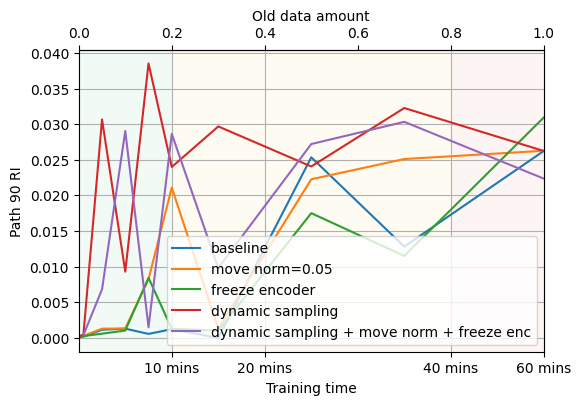

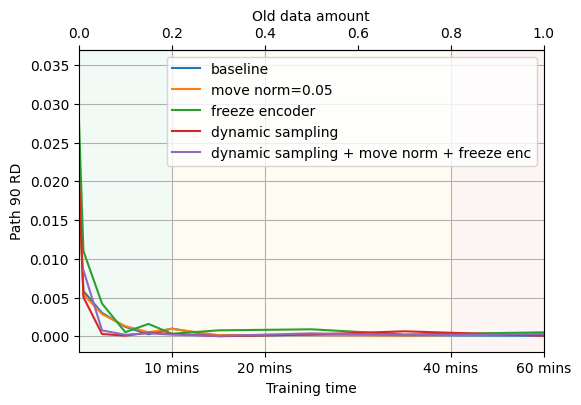

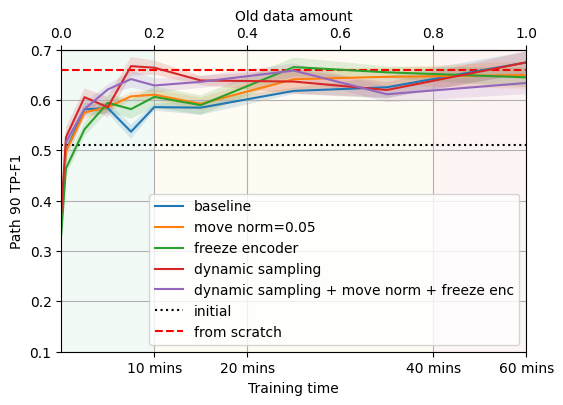

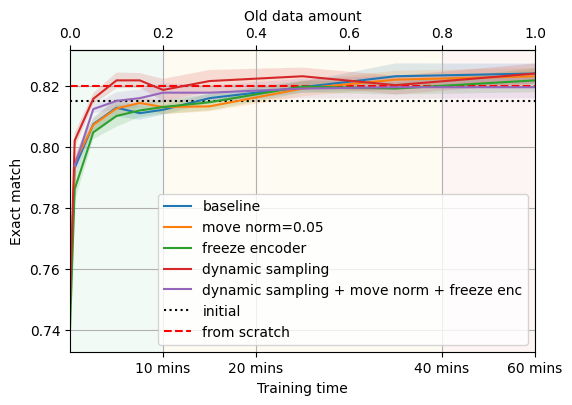

In [78]:
plot(dataframes, labels, "relative_improvement", "Path 90 RI")
plot(dataframes, labels, "relative_degradation", "Path 90 RD", ylim=(-0.002, 0.037), legend_loc='best')
plot(dataframes, labels, "cls/eval_PATH_tree_path_f1", "Path 90 TP-F1", ylim=(0.1, 0.7), initial=0.51, from_scratch=0.66)
plot(dataframes, labels, "eval_exact_match", "Exact match", initial=0.815, from_scratch=0.82)

# GetWeather 99

In [10]:
snips_getweather99_csv = '''
"Name","old_data_amount","relative_improvement","move_norm","tags","freeze_encoder","freeze_decoder","_wandb","cls/eval_GETWEATHER_tree_path_f1","cls/eval_GETWEATHER_tree_path_f1_std","relative_degradation_0.1","relative_degradation","eval_exact_match_std","eval_exact_match","n_negative_outliers","relative_improvement_0.1","n_positive_outliers"
"amber-meadow-3684 (move norm)","1","0.9411574570166146","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_move_norm""]","None","None","","0.9601586129504798","0.007377754867609824","0.02139980881179961","-0.00010501185728271892","0.005224549585117101","0.9514285714285716","1","0.9201166595532796","25"
"misty-darkness-3681 (move norm)","0.7","0","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_move_norm""]","None","None","","0.9578411562543364","0.006411518093367958","0.0207964103260891","0","0.003072259023943828","0.9514285714285714","0","0.8949657541206838","25"
"dry-blaze-3678 (move norm)","0.5","0","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_move_norm""]","None","None","","0.9657656455213772","0.00520185315178902","0.020987945653957223","0","0.0058684559732696704","0.95","0","1.006036217303823","23"
"vivid-sun-3675 (move norm)","0.3","0.9516036652429064","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_move_norm""]","None","None","","0.9494417177639216","0.005726149903820715","0.019852145711326864","-0.0004911513684041582","0.0034992710611188135","0.9457142857142856","3","0.9312012425429772","27"
"laced-snowball-3673 (move norm)","0.2","0.9522104040670272","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_move_norm""]","None","None","","0.9617568714333704","0.006979998551739466","0.02081690065120968","-0.00038991926956310016","0.007284313590846859","0.9471428571428572","1","0.9312012425429772","23"
"glad-pine-3672 (move norm)","0.15","0","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_move_norm""]","None","None","","0.9605021183041316","0.006023688928570946","0.020049564543420217","0","0.004711037842240359","0.9485714285714286","0","0.945285452950639","22"
"chocolate-fire-3671 (move norm)","0.1","0.8906046163065713","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_move_norm""]","None","None","","0.9460557865250973","0.010921002279318432","0.018497062812271783","-0.00005058935106128031","0.006226998490772369","0.9414285714285716","1","0.8725157965335876","24"
"stellar-wildflower-3668 (move norm)","0.05","0.9496398437994272","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_move_norm""]","None","None","","0.972082487753515","0.009285386114670934","0.018301865159666735","-0.0003949942190833342","0.005578749768504734","0.9371428571428572","2","0.9312012425429772","17"
"trim-haze-3666 (move norm)","0.01","0.7397829952816292","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_move_norm""]","None","None","","0.9621601681712788","0.008350206976985665","0.013595042268665904","-0.0010430692265740364","0.00569192051803903","0.912857142857143","9","0.7245232597345275","16"
"blooming-field-3665 (move norm)","0","0.1181728521532688","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_move_norm""]","None","None","","0.5292531568127087","0.016869158512419193","-0.09232494945765712","-0.09438945908122048","0.005601566836199309","0.7257142857142856","38","0.11616764696843394","3"
"morning-snow-3661 (dynamic sampling)","1","0","None","[""finetune"",""snips_get_weather_99_Aug17_bert_run_sample""]","None","None","","0.9621182494114032","0.007768259424414043","0.02271897258027411","0","0.0048445214165180744","0.9557142857142856","0","0.9096643352176552","27"
"hopeful-glitter-3659 (dynamic sampling)","0.7","1.0271210889285467","None","[""finetune"",""snips_get_weather_99_Aug17_bert_run_sample""]","None","None","","0.975984384807768","0.0061957892312968525","0.02104410333692593","-0.00032875983782502965","0.004432026302139613","0.9557142857142856","4","1.006036217303823","23"
"treasured-tree-3655 (dynamic sampling)","0.5","1.027181382041143","None","[""finetune"",""snips_get_weather_99_Aug17_bert_run_sample""]","None","None","","0.9657617263908724","0.007799900127265261","0.021028435872954426","-0.00015017765861008458","0.003813242232868341","0.9485714285714286","3","1.006036217303823","26"
"fanciful-wildflower-3651 (dynamic sampling)","0.3","0.973905464963244","None","[""finetune"",""snips_get_weather_99_Aug17_bert_run_sample""]","None","None","","0.9679515379738562","0.009860588159455015","0.021390760829297927","-0.0001493532088431217","0.005463235193135154","0.9514285714285714","2","0.9526556816488356","24"
"gentle-meadow-3648 (dynamic sampling)","0.2","1.025874384760906","None","[""finetune"",""snips_get_weather_99_Aug17_bert_run_sample""]","None","None","","0.9739037891352268","0.008140323214730459","0.02003308427332628","-0.00020167848369631456","0.004315373561998046","0.9471428571428572","3","1.006036217303823","19"
"celestial-music-3647 (dynamic sampling)","0.15","0.9730939428651392","None","[""finetune"",""snips_get_weather_99_Aug17_bert_run_sample""]","None","None","","0.9658751770833788","0.00974418779015418","0.020423813849300625","-0.00015084330315596597","0.003388154635894726","0.95","1","0.9526556816488356","25"
"silver-jazz-3643 (dynamic sampling)","0.1","0.9796149662564348","None","[""finetune"",""snips_get_weather_99_Aug17_bert_run_sample""]","None","None","","0.9620066157188274","0.006090064743240432","0.02078993927986743","-0.00005045657893519996","0.0013363062095621172","0.9485714285714286","1","0.9590374326157448","23"
"swept-lion-3642 (dynamic sampling)","0.05","0.9719331828416836","None","[""finetune"",""snips_get_weather_99_Aug17_bert_run_sample""]","None","None","","0.9660610504865244","0.01201841853194425","0.019179057731308808","-0.0004858371598476097","0.003677010764638202","0.9457142857142856","2","0.9526556816488356","20"
"rose-river-3640 (dynamic sampling)","0.01","0.9217726536362442","None","[""finetune"",""snips_get_weather_99_Aug17_bert_run_sample""]","None","None","","0.9485270234678278","0.009675656997132596","0.015252261186672656","-0.0006716244074261996","0.004738035414793411","0.9314285714285716","4","0.9059239441533206","16"
"driven-wave-3637 (dynamic sampling)","0","0.11338956771669924","None","[""finetune"",""snips_get_weather_99_Aug17_bert_run_sample""]","None","None","","0.5204179784920306","0.017425944873475856","-0.09827988658758743","-0.10053669188031111","0.00569192051803899","0.7157142857142857","38","0.11123305515609076","3"
"elated-frog-3636 (dynamic sampling)","0","","None","[""finetune"",""snips_get_weather_99_Aug17_bert_run_sample""]","None","None","","","","","","","","","",""
"earthy-glitter-3707 (freeze encoder)","1","0.9279533199139984","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","None","","0.953916115256231","0.007616713290781535","0.020457222317892335","-0.00011239428610631924","0.0048445214165180545","0.9485714285714286","2","0.907453266608196","24"
"devout-donkey-3704 (freeze encoder)","0.7","0","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","None","","0.9512782345204392","0.0062951665387422605","0.020446303737614226","0","0.006123724356957962","0.9485714285714286","0","0.8725157965335876","23"
"celestial-cherry-3702 (freeze encoder)","0.5","0","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","None","","0.9577562143382884","0.007144058364553175","0.02053994731328696","0","0.006487822187351794","0.95","0","0.9312012425429772","20"
"lyric-waterfall-3700 (freeze encoder)","0.3","0.9509275373876828","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","None","","0.9497467831551998","0.009271625990722817","0.01967052038788296","-0.0002760144572553966","0.006247448458762828","0.9457142857142856","1","0.9312012425429772","22"
"serene-wave-3698 (freeze encoder)","0.2","0.9488282293117608","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","None","","0.9537474402502818","0.008842606899538443","0.01759506382980866","-0.00011911331003302922","0.006832545167753187","0.9385714285714286","1","0.9312012425429772","17"
"sweet-violet-3695 (freeze encoder)","0.15","0.9503483937038064","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","None","","0.9617568714333704","0.006979998551739466","0.019122382972868817","-0.0004148823476945251","0.0065853888980663255","0.9428571428571428","3","0.9312012425429772","21"
"earthy-valley-3693 (freeze encoder)","0.1","0.9496013823867786","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","None","","0.9617568714333704","0.006979998551739466","0.017966190328101546","-0.00032660380831667696","0.0062474484587627995","0.94","2","0.9312012425429772","20"
"toasty-wood-3690 (freeze encoder)","0.05","0.8429860342329718","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","None","","0.9598135097336352","0.00693015009158916","0.017789249341473336","-0.0002676122179913309","0.00608192370211655","0.9357142857142856","3","0.8248429097361702","19"
"proud-terrain-3688 (freeze encoder)","0.01","0.7358578332916011","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","None","","0.9524261305641012","0.008827434638870727","0.009614843736804914","-0.0024260730470995195","0.008033729913715681","0.9028571428571428","11","0.7235331178993151","12"
"dutiful-plasma-3687 (freeze encoder)","0","0.13690590238059697","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","None","","0.5068709441040851","0.01854324863867625","-0.09502269643231932","-0.09717987445991748","0.005125964319431202","0.74","31","0.13466061332205567","4"
"distinctive-blaze-3724 (all)","1","0","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_best""]","0","None","","0.9416479914826772","0.00697120104300847","0.018518845490389978","0","0.004432026302139576","0.9414285714285716","0","0.8657942278239916","23"
"dandy-lake-3722 (all)","0.7","0.891825688940999","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_best""]","0","None","","0.9310733244975504","0.010751942982753768","0.017429291004582053","-0.0005858986599998862","0.006123724356957924","0.9371428571428572","2","0.8738620984217326","23"
"prime-universe-3720 (all)","0.5","0","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_best""]","0","None","","0.9557738218585012","0.011155794952249855","0.019583525779165323","0","0.004164965639175199","0.9457142857142856","0","0.9526556816488356","21"
"breezy-music-3718 (all)","0.3","0.9725548478297596","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_best""]","0","None","","0.9557738218585012","0.011155794952249855","0.019537955862015306","-0.0006346345720940741","0.004374088826398516","0.9428571428571428","2","0.9526556816488356","24"
"comic-fire-3716 (all)","0.2","0","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_best""]","0","None","","0.9560836677192248","0.009856836706284495","0.018356717273053248","0","0.004072055089639764","0.9428571428571428","0","0.9059239441533206","18"
"devoted-donkey-3715 (all)","0.15","0","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_best""]","0","None","","0.9578465650315304","0.011627312972100423","0.01908428658020117","0","0.004711037842240312","0.9442857142857144","0","0.9526556816488356","19"
"spring-bird-3714 (all)","0.1","0.8788891767730651","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_best""]","0","None","","0.9497644845324316","0.011170746631601652","0.018542867747702068","-0.0001760158638695175","0.0046014638309732426","0.9385714285714286","1","0.860009682153069","21"
"resilient-deluge-3712 (all)","0.05","0.9241514384324264","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_best""]","0","None","","0.9558341550888564","0.007869728488662273","0.01809790984793932","-0.00024196221411998685","0.004656573146573304","0.9357142857142856","1","0.9059239441533206","19"
"olive-field-3710 (all)","0.01","0.8385149054299919","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_best""]","0","None","","0.9284179845558794","0.017160809962087912","0.01279142056612589","-0.0010190419092008288","0.007542397172122462","0.917142857142857","5","0.8247191322111432","16"
"breezy-silence-3709 (all)","0","0.13677556203156352","0.1","[""finetune"",""snips_get_weather_99_Aug12_bert_run_best""]","0","None","","0.5093376639043737","0.018636127972877232","-0.09332554677868296","-0.09512656921929805","0.005802884574739987","0.7414285714285714","31","0.13466061332205567","4"
"dazzling-donkey-3767 (freeze enc and dec)","1","0.4518177818998692","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","0","","0.8222277340361905","0.017328757345458166","-0.0013441641442075562","-0.0003954043989235791","0.010630625761526576","0.8814285714285715","4","0.4521922678733785","14"
"spring-snowflake-3760 (freeze enc and dec)","0.7","0.4902335868056673","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","0","","0.862821482117839","0.005622759105997651","-0.0009955684857779902","-0.0005532745295708611","0.005463235193135107","0.8985714285714286","5","0.4908582957344124","12"
"usual-rain-3757 (freeze enc and dec)","0.5","0.4319158297434456","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","0","","0.8456896385062528","0.008557168295901496","-0.0015347912741111112","-0.0010075854348803948","0.004711037842240312","0.8699999999999999","6","0.4323786346874513","14"
"sparkling-dream-3751 (freeze enc and dec)","0.3","0.37198258195027967","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","0","","0.8346057167734366","0.006042415534457048","-0.001217567527770776","-0.0004179811047003081","0.005601566836199353","0.89","2","0.37248590105239543","13"
"vibrant-resonance-3746 (freeze enc and dec)","0.2","0.2747538011061167","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","0","","0.8322170827675984","0.010168312280017026","-0.003139569320870926","-0.0020254760035043947","0.007824607964359524","0.8785714285714284","8","0.2752940245239008","6"
"elated-frost-3742 (freeze enc and dec)","0.15","0.3588797259091556","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","0","","0.8470855781375157","0.011672127847779807","-0.0012160496206943682","-0.0005249097796903935","0.00975464305981976","0.8685714285714285","4","0.35944972547472365","10"
"celestial-durian-3737 (freeze enc and dec)","0.1","0.3296641874571886","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","0","","0.7977615810830969","0.00935128354752787","-0.008000193861443293","-0.009292793552413576","0.007371345514482261","0.8528571428571429","14","0.3280185313562045","4"
"solar-spaceship-3732 (freeze enc and dec)","0.05","0.2269431486577506","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","0","","0.644696318746033","0.00850406953751328","-0.04422624765414097","-0.04642721556617546","0.008253014291636674","0.8057142857142857","20","0.22495219765799773","4"
"elated-universe-3728 (freeze enc and dec)","0.01","0.11192877845302844","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","0","","0.5534934160018482","0.007845598453534719","-0.08328856062149809","-0.08367191419803514","0.00907733216224202","0.7457142857142857","30","0.11114304876880332","3"
"pleasant-lake-3726 (freeze enc and dec)","0","0.1181951961532025","None","[""finetune"",""snips_get_weather_99_Aug12_bert_run_freeze""]","0","0","","0.4532102604937244","0.01688072532447501","-0.14436523250627906","-0.14485578280612724","0.01","0.5942857142857143","41","0.11750636382146372","2"
'''

In [84]:
snips_getweather99 = pd.read_csv(StringIO(snips_getweather99_csv)).sort_values("old_data_amount")

_tag = '["finetune","snips_get_weather_99_Aug12_bert_run"]'
finetune_baseline = snips_getweather99[snips_getweather99.tags == _tag]

_tag = '["finetune","snips_get_weather_99_Aug17_bert_run_sample"]'
dynamic_sampling = snips_getweather99[snips_getweather99.tags == _tag]

_tag = '["finetune","snips_get_weather_99_Aug12_bert_run_move_norm"]'
move_norm_01 = snips_getweather99[snips_getweather99.tags == _tag]

_tag = '["finetune","snips_get_weather_99_Aug12_bert_run_freeze"]'
freeze = snips_getweather99[snips_getweather99.tags == _tag]
freeze_encoder = freeze[(freeze.freeze_encoder == "0") & (freeze.freeze_decoder == "None")] # & (freeze.freeze_head == "None")]
freeze_encdec = freeze[(freeze.freeze_encoder == "0") & (freeze.freeze_decoder == "0")] # & (freeze.freeze_head == "None")]

_tag = '["finetune","snips_get_weather_99_Aug12_bert_run_best"]'
combination = snips_getweather99[snips_getweather99.tags == _tag]

dataframes = [finetune_baseline, dynamic_sampling, move_norm_01, freeze_encoder, freeze_encdec, combination]
labels = ["baseline", "dynamic sampling", "move norm=0.1", "freeze encoder", "freeze encoder and decoder", "dynamic sampling + move norm + freeze" ]

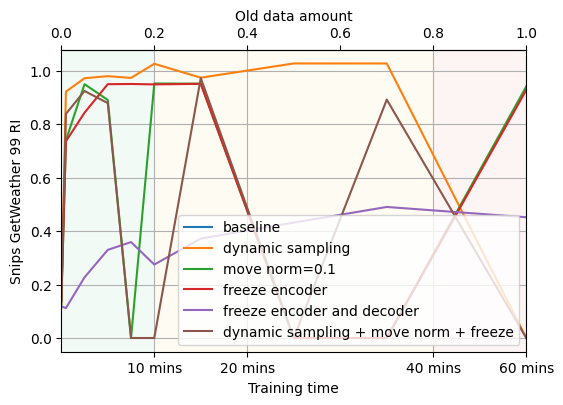

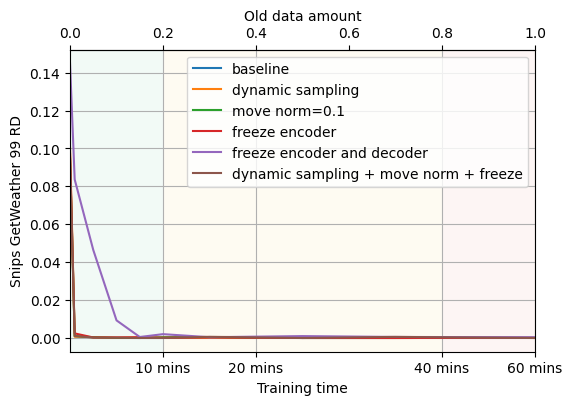

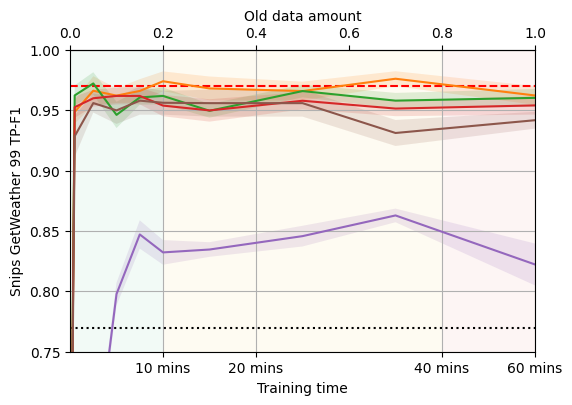

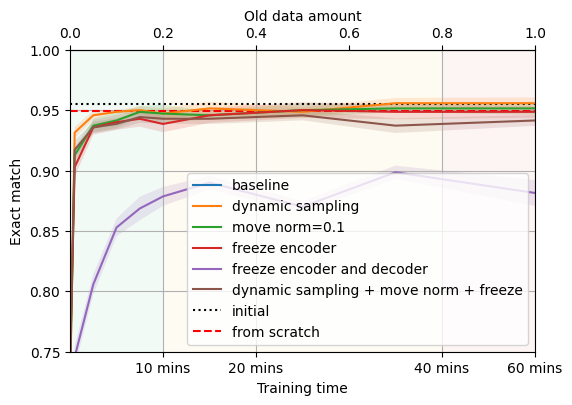

In [85]:
class_name = 'Snips GetWeather 99'

plot(dataframes, labels, "relative_improvement", f"{class_name} RI")
plot(dataframes, labels, "relative_degradation", f"{class_name} RD", legend_loc='best')
plot(dataframes, labels, "cls/eval_GETWEATHER_tree_path_f1", f"{class_name} TP-F1", initial=0.77, from_scratch=0.97, ylim=(0.75, 1.0), legend_loc=None)
plot(dataframes, labels, "eval_exact_match", "Exact match", initial=0.955, from_scratch=0.949, ylim=(0.75, 1.0))

# GetWeather 90

In [13]:
snips_getweather90_csv = '''
"Name","old_data_amount","relative_improvement","freeze_encoder","tags","move_norm","_wandb","relative_degradation","cls/eval_GETWEATHER_tree_path_f1_std","eval_exact_match","cls/eval_GETWEATHER_tree_path_f1","eval_exact_match_std","relative_degradation_0","relative_improvement_0","n_negative_outliers","n_positive_outliers"
"happy-eon-3745 (baseline)","1","0.0051115449709200735","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_baseline""]","None","","-0.000051890061531832465","0.003478584462678682","0.9371428571428572","0.976646995047059","0.004134227465282209","-0.0001458243179042843","0.005967243353132381","1","12"
"wandering-snowball-3743 (baseline)","0.7","0.005592332396535933","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_baseline""]","None","","-0.00005356777700946999","0.004158308094396052","0.9342857142857142","0.9766580709526924","0.0013363062095621172","-0.0001762960696326905","0.006681745820722092","1","12"
"visionary-totem-3740 (baseline)","0.5","0","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_baseline""]","None","","0","0.005236425733579648","0.9271428571428572","0.9661227437860914","0.0020824828195875997","-0.00015635367101183954","0.005388115618778564","0","12"
"lyric-dream-3739 (baseline)","0.3","0.0057566793585818584","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_baseline""]","None","","-0.000026022016130636837","0.0032381012395965147","0.9342857142857144","0.978828032450911","0.0030722590239437844","-0.0002421969517496574","0.006895640133898546","1","13"
"wandering-wind-3738 (baseline)","0.2","0.004995112543358729","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_baseline""]","None","","-0.00010666817442304464","0.00391558422185395","0.9314285714285716","0.9745779836403904","0.0008748177652797034","-0.0004782291772072786","0.00553740129494992","1","14"
"fragrant-shape-3736 (baseline)","0.15","0.004856906021836561","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_baseline""]","None","","-0.00005142391784821498","0.003957083723696142","0.93","0.9830446625246598","0.00262445329583911","-0.0005385835895685796","0.005620413392660916","1","11"
"trim-meadow-3734 (baseline)","0.1","0.0050900051330185015","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_baseline""]","None","","-0.000026022016130636837","0.00391558422185395","0.9285714285714284","0.9745779836403904","0.0029880715233359736","-0.0004456532225782313","0.005434158226508943","1","13"
"pretty-silence-3733 (baseline)","0.05","0.0015935743407157275","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_baseline""]","None","","-0.0007097573562473904","0.010444029234929387","0.9242857142857142","0.9465314136991076","0.002901442287370019","-0.001161682150223335","0.0030127635244340924","4","8"
"light-water-3731 (baseline)","0.01","0.002006635212774477","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_baseline""]","None","","-0.0003743579644373122","0.008483006498739619","0.9214285714285714","0.9535998135760811","0.004656573146573347","-0.00090822031553461","0.0034210887084562274","3","10"
"solar-spaceship-3730 (baseline)","0","0","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_baseline""]","None","","-0.02629417714491584","0.016875373741083662","0.8685714285714285","0.7907929718157843","0.005369034420847448","-0.026786735211140233","0.0003580698750907522","18","0"
"fanciful-firebrand-3758 (move norm 0.05)","0.7","0.006908538332638244","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_move_norm005""]","0.05","","-0.000026022016130636837","0.003957083723696142","0.9385714285714286","0.9830446625246598","0.002422260708259016","-0.00008607015098219823","0.0078158262926883","1","18"
"splendid-leaf-3755 (move norm 0.05)","0.5","0.004780350552403978","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_move_norm005""]","0.05","","-0.00007958979314010683","0.004629304271117635","0.93","0.9788394714808814","0.0023690177073967056","-0.000406384718489446","0.005446867598652217","2","12"
"whole-yogurt-3754 (move norm 0.05)","0.2","0.005986747189280308","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_move_norm005""]","0.05","","-0.00007958979314010683","0.0054135907740031014","0.9328571428571428","0.97664127305243","0.0034992710611188135","-0.0003862278993226541","0.007193771709542544","2","13"
"morning-glade-3752 (move norm 0.05)","0.1","0.004491692217884521","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_move_norm005""]","0.05","","-0.000026022016130636837","0.00391558422185395","0.9285714285714284","0.9745779836403904","0.0025253813613805177","-0.000426182038644121","0.005124781712152691","1","10"
"glorious-elevator-3750 (move norm 0.05)","0.05","0.005194692617580808","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_move_norm005""]","0.05","","-0.00010056983320169088","0.00618227684099974","0.9314285714285716","0.9684210695473512","0.0031134992453861845","-0.00036074732168023987","0.00589471474880927","1","13"
"driven-elevator-3748 (move norm 0.05)","0","0","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_move_norm005""]","0.05","","-0.024569282286187967","0.013423273209954048","0.8699999999999999","0.7992085576606812","0.004974424384708596","-0.02506184035241236","0.0003580698750907522","18","0"
"super-dew-3770 (same lr)","1","0","0","[""finetune"",""snips_get_weather_90_Aug18_bert_run_samelr""]","None","","0","0.006218421662881389","0.9114285714285714","0.927417876248701","0.004315373561998045","","","0","0"
"blooming-breeze-3769 (same lr)","0.7","0","0","[""finetune"",""snips_get_weather_90_Aug18_bert_run_samelr""]","None","","0","0.00495473447223003","0.9114285714285714","0.9275522921447814","0.004738035414793411","","","0","0"
"whole-deluge-3768 (same lr)","0.5","0","0","[""finetune"",""snips_get_weather_90_Aug18_bert_run_samelr""]","None","","0","0.00495473447223003","0.9114285714285714","0.9275522921447814","0.004738035414793411","","","0","0"
"unique-plasma-3766 (same lr)","0.3","0","0","[""finetune"",""snips_get_weather_90_Aug18_bert_run_samelr""]","None","","0","0.00495473447223003","0.9114285714285714","0.9275522921447814","0.004738035414793411","","","0","0"
"legendary-dust-3765 (same lr)","0.2","0","0","[""finetune"",""snips_get_weather_90_Aug18_bert_run_samelr""]","None","","0","0.003829255914561922","0.91","0.9231836486190328","0.004164965639175199","","","0","0"
"bumbling-hill-3764 (same lr)","0.15","0","0","[""finetune"",""snips_get_weather_90_Aug18_bert_run_samelr""]","None","","0","0.00495473447223003","0.9114285714285714","0.9275522921447814","0.004738035414793411","","","0","0"
"fragrant-glade-3763 (same lr)","0.1","0","0","[""finetune"",""snips_get_weather_90_Aug18_bert_run_samelr""]","None","","0","0.00495473447223003","0.9114285714285714","0.9275522921447814","0.004738035414793411","","","0","0"
"resilient-field-3762 (same lr)","0.05","0","0","[""finetune"",""snips_get_weather_90_Aug18_bert_run_samelr""]","None","","0","0.00495473447223003","0.9114285714285714","0.9275522921447814","0.004738035414793411","","","0","0"
"dashing-sun-3761 (same lr)","0.01","0","0","[""finetune"",""snips_get_weather_90_Aug18_bert_run_samelr""]","None","","0","0.00495473447223003","0.9114285714285714","0.9275522921447814","0.004738035414793411","","","0","0"
"pious-sponge-3759 (same lr)","0","0","0","[""finetune"",""snips_get_weather_90_Aug18_bert_run_samelr""]","None","","0","0.006218421662881389","0.9114285714285714","0.927417876248701","0.004315373561998045","","","0","0"
"true-resonance-3776 (average 0.9)","0.7","0.005592332396535933","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_average09""]","None","","-0.00005356777700946999","0.004158308094396052","0.9342857142857142","0.9766580709526924","0.0013363062095621172","-0.0001762960696326905","0.006681745820722092","1","12"
"dashing-wave-3775 (average 0.9)","0.5","0","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_average09""]","None","","0","0.005236425733579648","0.9271428571428572","0.9661227437860914","0.0020824828195875997","-0.00015635367101183954","0.005388115618778564","0","12"
"dazzling-shadow-3774 (average 0.9)","0.2","0.004995112543358729","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_average09""]","None","","-0.00010666817442304464","0.00391558422185395","0.9314285714285716","0.9745779836403904","0.0008748177652797034","-0.0004782291772072786","0.00553740129494992","1","14"
"distinctive-wildflower-3773 (average 0.9)","0.1","0.0050900051330185015","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_average09""]","None","","-0.000026022016130636837","0.00391558422185395","0.9285714285714284","0.9745779836403904","0.0029880715233359736","-0.0004456532225782313","0.005434158226508943","1","13"
"dark-dragon-3772 (average 0.9)","0.05","0.0015935743407157275","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_average09""]","None","","-0.0007097573562473904","0.010444029234929387","0.9242857142857142","0.9465314136991076","0.002901442287370019","-0.001161682150223335","0.0030127635244340924","4","8"
"dauntless-terrain-3771 (average 0.9)","0","0","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_average09""]","None","","-0.02629417714491584","0.016875373741083662","0.8685714285714285","0.7907929718157843","0.005369034420847448","-0.026786735211140233","0.0003580698750907522","18","0"
"northern-forest-3783 (average 0.5)","0.7","0.005592332396535933","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_average05""]","None","","-0.00005356777700946999","0.004158308094396052","0.9342857142857142","0.9766580709526924","0.0013363062095621172","-0.0001762960696326905","0.006681745820722092","1","12"
"vibrant-totem-3781 (average 0.5)","0.5","0","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_average05""]","None","","0","0.005236425733579648","0.9271428571428572","0.9661227437860914","0.0020824828195875997","-0.00015635367101183954","0.005388115618778564","0","12"
"neat-universe-3780 (average 0.5)","0.2","0.004995112543358729","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_average05""]","None","","-0.00010666817442304464","0.00391558422185395","0.9314285714285716","0.9745779836403904","0.0008748177652797034","-0.0004782291772072786","0.00553740129494992","1","14"
"astral-river-3779 (average 0.5)","0.1","0.0050900051330185015","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_average05""]","None","","-0.000026022016130636837","0.00391558422185395","0.9285714285714284","0.9745779836403904","0.0029880715233359736","-0.0004456532225782313","0.005434158226508943","1","13"
"lively-microwave-3778 (average 0.5)","0.05","0.0015935743407157275","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_average05""]","None","","-0.0007097573562473904","0.010444029234929387","0.9242857142857142","0.9465314136991076","0.002901442287370019","-0.001161682150223335","0.0030127635244340924","4","8"
"blooming-universe-3777 (average 0.5)","0","0","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_average05""]","None","","-0.02629417714491584","0.016875373741083662","0.8685714285714285","0.7907929718157843","0.005369034420847448","-0.026786735211140233","0.0003580698750907522","18","0"
"stoic-breeze-3821 (dynamic sampling)","1","0.0051115449709200735","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_sample""]","None","","-0.000051890061531832465","0.003478584462678682","0.9371428571428572","0.976646995047059","0.004134227465282209","-0.0001458243179042843","0.005967243353132381","1","12"
"desert-terrain-3818 (dynamic sampling)","0.7","0.006213012232533006","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_sample""]","None","","-0.00017709474798804765","0.0050315757083811245","0.9357142857142856","0.974531240711265","0.003745745886321956","-0.0003245914528256826","0.007356004767006233","3","13"
"elated-cosmos-3814 (dynamic sampling)","0.5","0.005474404050476926","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_sample""]","None","","-0.00013018859480428286","0.006672912450609786","0.93","0.9744288898396832","0.00262445329583911","-0.0002106254773634898","0.006336730929270284","2","13"
"worldly-snowball-3812 (dynamic sampling)","0.3","0.0049563455835689545","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_sample""]","None","","-0.00005245201253343106","0.005553671901233529","0.9342857142857144","0.9788044126253952","0.004711037842240312","-0.0002032058234215084","0.00595272939003799","1","10"
"vital-sound-3809 (dynamic sampling)","0.2","0.004678332515436178","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_sample""]","None","","-0.0001047140499864038","0.005311110673808512","0.9357142857142856","0.9726035334030044","0.005532833351724862","-0.0003769568446427478","0.0059573330764730046","1","11"
"wandering-gorge-3808 (dynamic sampling)","0.15","0.004548060044744279","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_sample""]","None","","-0.00007752573813550083","0.005385262282787086","0.9342857142857142","0.9746136871487712","0.004432026302139576","-0.00019493222538279891","0.005816980859353109","2","10"
"zesty-sea-3804 (dynamic sampling)","0.1","0.004899875365937089","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_sample""]","None","","-0.000026138474868257092","0.0057713291601300155","0.9285714285714286","0.9682390638241144","0.006081923702116576","-0.0004430999245962942","0.0057748894620047375","1","13"
"crisp-leaf-3803 (dynamic sampling)","0.05","0.002966481188492326","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_sample""]","None","","-0.0002037492658390391","0.007906629044149129","0.9242857142857142","0.9602643143253196","0.005369034420847494","-0.0006173543226068014","0.003921676054969962","2","10"
"gentle-salad-3802 (dynamic sampling)","0.01","0.003131906226843954","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_sample""]","None","","-0.0005227050276888707","0.00744113931786369","0.9214285714285714","0.9643849411128242","0.0037457458863220097","-0.0007885268338566826","0.004315005271951476","4","11"
"crimson-fog-3801 (dynamic sampling)","0","0","None","[""finetune"",""snips_get_weather_90_Aug18_bert_run_sample""]","None","","-0.02629417714491584","0.016875373741083662","0.8685714285714285","0.7907929718157843","0.005369034420847448","-0.026786735211140233","0.0003580698750907522","18","0"
'''

In [56]:
snips_getweather90 = pd.read_csv(StringIO(snips_getweather90_csv)).sort_values("old_data_amount")

_tag = '["finetune","snips_get_weather_90_Aug18_bert_run_baseline"]'
finetune_baseline = snips_getweather90[snips_getweather90.tags == _tag]

_tag = '["finetune","snips_get_weather_90_Aug18_bert_run_sample"]'
dynamic_sampling = snips_getweather90[snips_getweather90.tags == _tag]

_tag = '["finetune","snips_get_weather_90_Aug18_bert_run_move_norm005"]'
move_norm_005 = snips_getweather90[snips_getweather90.tags == _tag]

_tag = '["finetune","snips_get_weather_90_Aug18_bert_run_samelr"]'
same_lr = snips_getweather90[snips_getweather90.tags == _tag]

_tag = '["finetune","snips_get_weather_90_Aug18_bert_run_average09"]'
average09 = snips_getweather90[snips_getweather90.tags == _tag]

_tag = '["finetune","snips_get_weather_90_Aug18_bert_run_average05"]'
average05 = snips_getweather90[snips_getweather90.tags == _tag]

_tag = '["finetune","snips_get_weather_90_Aug18_bert_run_freeze"]'
freeze = snips_getweather90[snips_getweather90.tags == _tag]
freeze = freeze[(freeze.freeze_encoder == "0")] # & (freeze.freeze_decoder == "None") & (freeze.freeze_head == "None")]

_tag = '["finetune","snips_get_weather_90_Aug18_bert_run_best"]'
combination = snips_getweather90[snips_getweather90.tags == _tag]

dataframes = [finetune_baseline, dynamic_sampling, move_norm_005, average09, average05, freeze, combination]
labels = ["baseline", "dynamic sampling", "move norm=0.05", "average09", "average05", "freeze encoder", "dynamic sampling + move norm + freeze"]

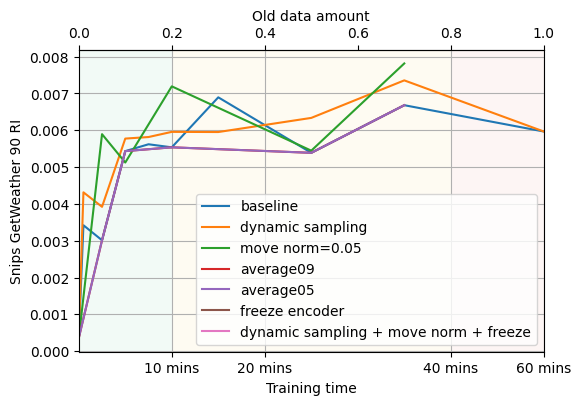

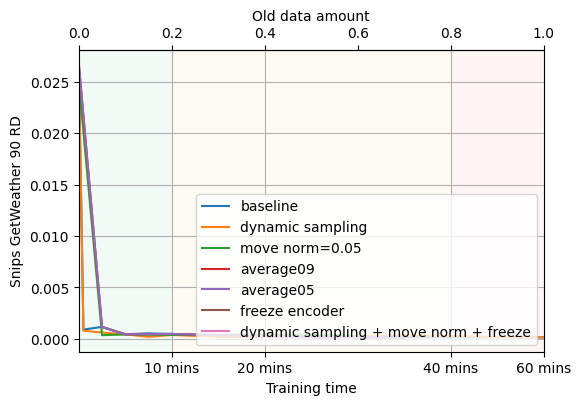

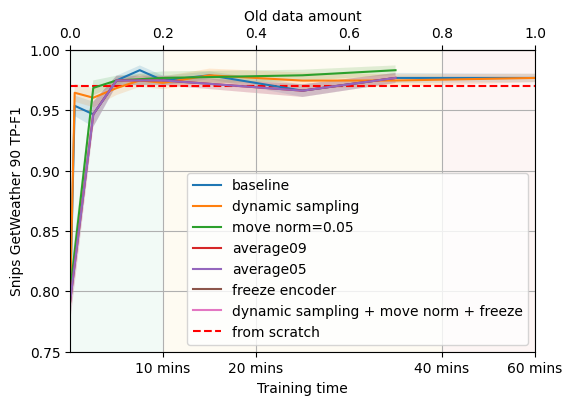

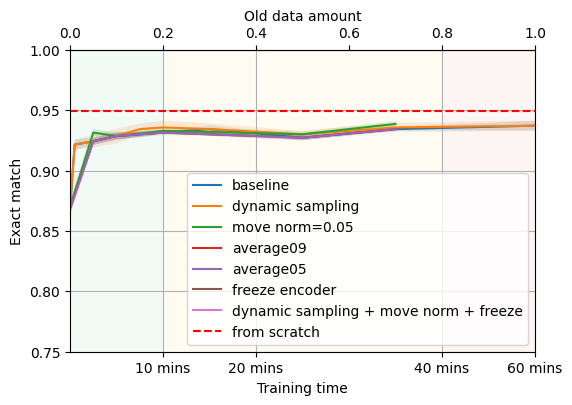

In [57]:
class_name = 'Snips GetWeather 90'

plot(dataframes, labels, "relative_improvement_0", f"{class_name} RI")
plot(dataframes, labels, "relative_degradation_0", f"{class_name} RD")
plot(dataframes, labels, "cls/eval_GETWEATHER_tree_path_f1", f"{class_name} TP-F1", initial=None, from_scratch=0.97, ylim=(0.75, 1.0))
plot(dataframes, labels, "eval_exact_match", "Exact match", initial=None, from_scratch=0.949, ylim=(0.75, 1.0))

# Dropout (NAME_EVENT)

In [16]:
dropout_name_event_csv = """
Name	old_data_amount	relative_improvement	dropout	tags	_wandb	relative_degradation	eval_exact_match_std	cls/eval_NAME_EVENT_tree_path_f1_std	cls/eval_NAME_EVENT_tree_path_f1	eval_exact_match
pleasant-gorge-3953 (dropout)	0.5	0	0.6	["name_event_Aug14_dropout"]		-9.13701E-02	3.06122E-03	2.53887E-02	5.47114E-01	5.87629E-01
elated-dawn-3951 (dropout)	0.5	5.84615E-03	0.5	["name_event_Aug14_dropout"]		-1.68359E-02	2.37508E-03	1.44087E-02	7.42392E-01	7.80367E-01
atomic-surf-3946 (dropout)	0.5	2.89895E-02	0.4	["name_event_Aug14_dropout"]		-4.70421E-04	1.36125E-03	1.1405E-02	8.22783E-01	8.15554E-01
trim-glade-3942 (dropout)	0.5	3.20582E-02	0.3	["name_event_Aug14_dropout"]		-2.91763E-05	2.75223E-03	1.08747E-02	8.28586E-01	8.18019E-01
lemon-smoke-3939 (dropout)	0.5	2.34974E-02	0.2	["name_event_Aug14_dropout"]		-1.78661E-04	2.34362E-03	6.21378E-03	8.32356E-01	8.18243E-01
denim-cosmos-3935 (dropout)	0.5	2.18515E-02	0.1	["name_event_Aug14_dropout"]		-3.43198E-04	2.93453E-03	7.00479E-03	7.83086E-01	8.13088E-01
balmy-feather-3934 (dropout)	0.5	8.17252E-03	0	["name_event_Aug14_dropout"]		-2.01489E-03	2.1891E-03	8.04526E-03	7.81831E-01	8.13537E-01
sage-star-3932 (dropout)	0.3	2.32659E-05	0.6	["name_event_Aug14_dropout"]		-4.90982E-02	3.78366E-03	1.06328E-02	7.1909E-01	6.82205E-01
lyric-universe-3931 (dropout)	0.3	0	0.5	["name_event_Aug14_dropout"]		-2.06039E-02	2.75687E-03	1.22103E-02	7.19863E-01	7.72075E-01
deft-voice-3930 (dropout)	0.3	2.06904E-02	0.4	["name_event_Aug14_dropout"]		-1.3461E-03	2.08503E-03	7.00382E-03	7.74684E-01	8.06141E-01
wandering-puddle-3928 (dropout)	0.3	2.27998E-02	0.3	["name_event_Aug14_dropout"]		-4.61538E-04	2.90869E-03	1.471E-02	7.8129E-01	8.17571E-01
misunderstood-grass-3926 (dropout)	0.3	3.08647E-02	0.2	["name_event_Aug14_dropout"]		-1.97656E-04	3.33534E-03	1.33092E-02	8.06186E-01	8.19588E-01
quiet-tree-3924 (dropout)	0.3	3.08807E-03	0.1	["name_event_Aug14_dropout"]		-6.76261E-04	3.44497E-03	8.42825E-03	7.95288E-01	8.14433E-01
sage-voice-3922 (dropout)	0.3	2.058E-02	0	["name_event_Aug14_dropout"]		-3.49195E-03	2.60808E-03	9.32982E-03	7.46383E-01	8.08606E-01
pious-frost-3920 (dropout)	0.05	2.47121E-05	0.6	["name_event_Aug14_dropout"]		-2.19231E-02	3.32085E-03	7.52812E-03	7.09394E-01	7.72524E-01
effortless-sea-3918 (dropout)	0.05	7.17949E-03	0.5	["name_event_Aug14_dropout"]		-1.92567E-02	3.38115E-03	1.21923E-02	6.45883E-01	7.66249E-01
crisp-wave-3916 (dropout)	0.05	5.84615E-03	0.4	["name_event_Aug14_dropout"]		-5.75677E-03	2.90359E-03	1.03676E-02	7.03265E-01	7.94935E-01
woven-blaze-3913 (dropout)	0.05	2.96996E-02	0.3	["name_event_Aug14_dropout"]		-3.3397E-03	1.82167E-03	6.17708E-03	7.4233E-01	8.06589E-01
pleasant-pond-3909 (dropout)	0.05	2.06529E-02	0.2	["name_event_Aug14_dropout"]		-4.19988E-04	1.91986E-03	7.58314E-03	7.45274E-01	8.09502E-01
expert-elevator-3906 (dropout)	0.05	2.02254E-02	0.1	["name_event_Aug14_dropout"]		-3.23581E-03	3.45516E-03	9.37749E-03	7.02043E-01	8.06813E-01
olive-paper-3903 (dropout)	0.05	2.07708E-02	0	["name_event_Aug14_dropout"]		-3.98321E-04	2.94052E-03	1.13189E-02	6.95436E-01	8.09951E-01
legendary-snowflake-3542 (dropout)	0.2	1.67894E-05	0.7	["name_event_Aug14_dropout"]		-2.47493E-02	2.50649E-03	9.76145E-03	6.56419E-01	7.68266E-01
exalted-violet-3540 (dropout)	0.2	0	0.6	["name_event_Aug14_dropout"]		-3.12823E-02	2.26101E-03	5.64061E-03	7.15211E-01	7.37114E-01
flowing-wood-3538 (dropout)	0.2	1.18681E-02	0.5	["name_event_Aug14_dropout"]		-1.4106E-02	2.21994E-03	9.7328E-03	7.3016E-01	7.84401E-01
peach-resonance-3536 (dropout)	0.2	2.85768E-02	0.4	["name_event_Aug14_dropout"]		-6.64887E-04	2.5673E-03	1.68943E-02	7.94067E-01	8.11968E-01
restful-elevator-3534 (dropout)	0.2	2.12434E-02	0.3	["name_event_Aug14_dropout"]		-7.77353E-04	1.79442E-03	6.85793E-03	8.03776E-01	8.14657E-01
young-snow-3532 (dropout)	0.2	2.10995E-02	0.2	["name_event_Aug14_dropout"]		-5.77407E-04	2.61609E-03	1.53137E-02	7.91604E-01	8.16002E-01
classic-grass-3530 (dropout)	0.2	2.08583E-02	0.1	["name_event_Aug14_dropout"]		-1.37937E-03	2.84115E-03	1.02458E-02	7.94009E-01	8.12864E-01
denim-snow-3528 (dropout)	0.2	2.11408E-02	0	["name_event_Aug14_dropout"]		-5.215E-04	3.3277E-03	6.97239E-03	7.59946E-01	8.12864E-01
resilient-fog-3514 (dropout)	0.1	1.67894E-05	0.7	["name_event_Aug14_dropout"]		-2.34744E-02	2.72074E-03	1.18365E-02	6.58986E-01	7.723E-01
icy-resonance-3512 (dropout)	0.1	2.32659E-05	0.6	["name_event_Aug14_dropout"]		-2.22174E-02	2.23538E-03	1.07618E-02	6.99561E-01	7.6468E-01
glorious-durian-3508 (dropout)	0.1	0	0.5	["name_event_Aug14_dropout"]		-1.98317E-02	3.60912E-03	1.08438E-02	7.1073E-01	7.74989E-01
divine-silence-3507 (dropout)	0.1	2.03558E-02	0.4	["name_event_Aug14_dropout"]		-3.11588E-03	2.15916E-03	1.01902E-02	7.62914E-01	8.03675E-01
stellar-donkey-3504 (dropout)	0.1	2.27001E-02	0.3	["name_event_Aug14_dropout"]		-6.5372E-04	2.51754E-03	1.25639E-02	7.60767E-01	8.12864E-01
driven-bush-3501 (dropout)	0.1	2.74297E-02	0.2	["name_event_Aug14_dropout"]		-3.61022E-04	3.32564E-03	1.37291E-02	7.50146E-01	8.13313E-01
fancy-dust-3497 (dropout)	0.1	2.84497E-02	0.1	["name_event_Aug14_dropout"]		-2.2232E-04	2.51524E-03	1.10007E-02	7.47839E-01	8.14433E-01
polar-bee-3492 (dropout)	0.1	2.08217E-02	0	["name_event_Aug14_dropout"]		-7.87514E-04	3.13339E-03	7.85567E-03	7.44315E-01	8.12864E-01
clean-yogurt-3472 (dropout)	0.01	1.67894E-05	0.7	["name_event_Aug14_dropout"]		-1.19705E-02	3.21565E-03	1.09474E-02	6.99169E-01	7.91798E-01
solar-meadow-3469 (dropout)	0.01	2.47121E-05	0.6	["name_event_Aug14_dropout"]		-1.27506E-02	3.03307E-03	7.13033E-03	7.34049E-01	7.90453E-01
spring-snowball-3465 (dropout)	0.01	1.91806E-03	0.5	["name_event_Aug14_dropout"]		-2.19111E-02	2.41686E-03	1.30245E-02	6.50857E-01	7.63783E-01
whole-pond-3461 (dropout)	0.01	2.2668E-02	0.4	["name_event_Aug14_dropout"]		-1.48945E-02	2.88542E-03	1.46194E-02	6.18057E-01	7.79471E-01
morning-eon-3459 (dropout)	0.01	2.85057E-03	0.3	["name_event_Aug14_dropout"]		-9.69204E-03	2.69983E-03	1.17545E-02	6.25866E-01	7.8978E-01
super-voice-3457 (dropout)	0.01	0.02	0.2	["name_event_Aug14_dropout"]		-8.42822E-03	3.55948E-03	7.74722E-03	6.32042E-01	7.96504E-01
fresh-meadow-3454 (dropout)	0.01	1.1258E-04	0.1	["name_event_Aug14_dropout"]		-6.06063E-03	2.50591E-03	8.79706E-03	6.45693E-01	7.96504E-01
zany-pyramid-3451 (dropout)	0.01	1.31802E-02	0	["name_event_Aug14_dropout"]		-6.71586E-03	2.80776E-03	8.02903E-03	6.05677E-01	7.93366E-01
"""

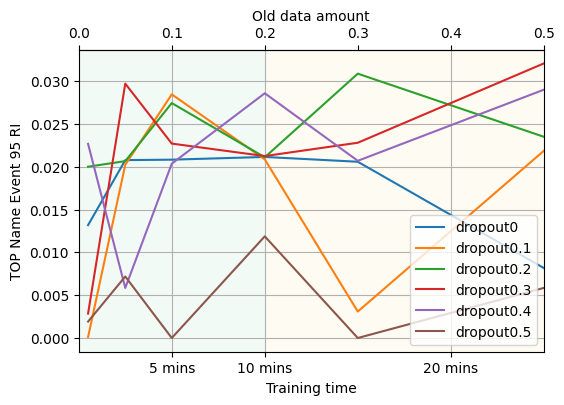

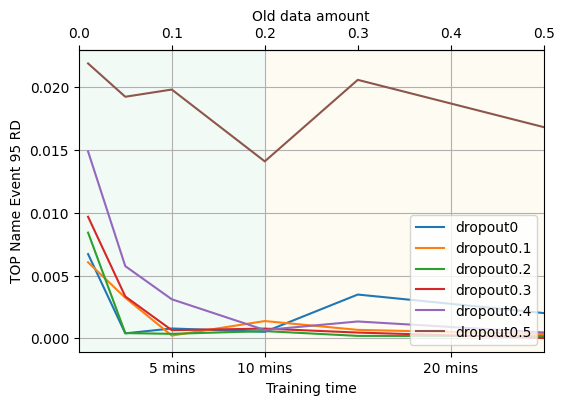

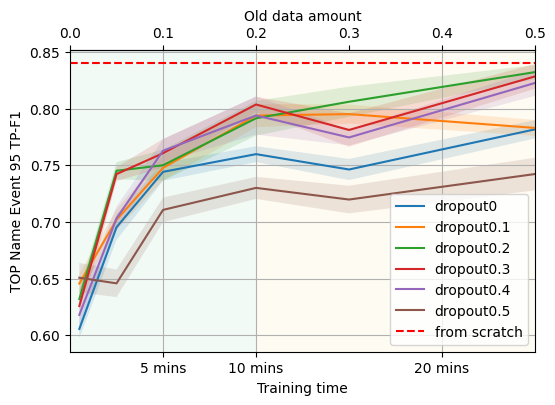

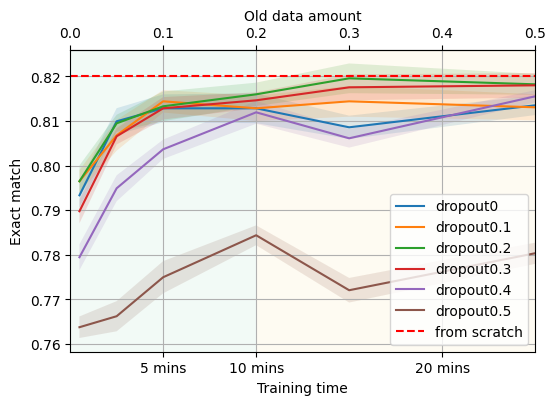

In [17]:
dataframe = pd.read_table(StringIO(dropout_name_event_csv)).sort_values("old_data_amount")

dropout_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

dataframes = [
    dataframe[dataframe.dropout == d] for d in dropout_values
]
labels = [f"dropout{d}" for d in dropout_values]

class_name = 'TOP Name Event 95'

plot(dataframes, labels, "relative_improvement", f"{class_name} RI", xlim=(0, 0.5))
plot(dataframes, labels, "relative_degradation", f"{class_name} RD", xlim=(0, 0.5))
plot(dataframes, labels, "cls/eval_NAME_EVENT_tree_path_f1", f"{class_name} TP-F1", initial=None, from_scratch=0.84, xlim=(0, 0.5))
plot(dataframes, labels, "eval_exact_match", "Exact match", initial=None, from_scratch=0.82, xlim=(0, 0.5))

# Weight decay (NAME_EVENT)

In [18]:
weight_decay_name_event_csv = '''
"Name","old_data_amount","relative_improvement","dropout","tags","weight_decay","_wandb","relative_degradation","cls/eval_NAME_EVENT_tree_path_f1_std","eval_exact_match_std","eval_exact_match","cls/eval_NAME_EVENT_tree_path_f1"
"azure-pyramid-3955 (weight decay)","0.05","0.02077082308000287","0","[""name_event_Aug14_weight_decay""]","0","","-0.0003983212637737055","0.011318897576051465","0.002940518585976079","0.8099509489894613","0.695436135970139"
"glad-music-3516 (weight decay)","0.1","0.02082168949878784","0","[""name_event_Aug14_weight_decay""]","0","","-0.0007875140814148946","0.00785567045992164","0.003133394091111336","0.8128643654771326","0.7443153622165524"
"serene-silence-3544 (weight decay)","0.2","0.02114083583888858","0","[""name_event_Aug14_weight_decay""]","0","","-0.0005215000467362683","0.0069723915904039415","0.0033276962981385054","0.8128643654771326","0.7599463849965303"
"royal-river-3973 (weight decay)","0.5","0.008172516438055026","0","[""name_event_Aug14_weight_decay""]","0","","-0.002014891886916158","0.008045256569897158","0.002189100200048361","0.813536602982","0.7818312251398657"
"eager-cosmos-3962 (weight decay)","0.3","0.02057995464963844","0","[""name_event_Aug14_weight_decay""]","0","","-0.0034919526024695053","0.00932982349684874","0.0026080773988921353","0.8086062227581616","0.7463833621827627"
"glad-snowball-3475 (weight decay)","0.01","0.01318023966250343","0","[""name_event_Aug14_weight_decay""]","0","","-0.006715857926868224","0.008029033999440174","0.00280775989365714","0.7933663061637211","0.6056769999417371"
"trim-paper-3546 (weight decay)","0.2","0.02107477360465633","0","[""name_event_Aug14_weight_decay""]","0.00001","","-0.0005215000467362683","0.009376748772787573","0.00328108258515125","0.8121919709587871","0.7541888665324873"
"wobbly-flower-3965 (weight decay)","0.3","0.001582677305148048","0","[""name_event_Aug14_weight_decay""]","0.00001","","-0.0002241809072713107","0.010794271711516848","0.0026684366598694596","0.8108472761301829","0.7827408823050712"
"eager-rain-3975 (weight decay)","0.5","0.008243392019763863","0","[""name_event_Aug14_weight_decay""]","0.00001","","-0.0017439181970847508","0.00461927776202715","0.002134429185087483","0.8137606612151587","0.791516623616015"
"young-butterfly-3956 (weight decay)","0.05","0.020792158409211933","0","[""name_event_Aug14_weight_decay""]","0.00001","","-0.00038830335710144433","0.01224731461970424","0.0033438497102916383","0.8097269221589981","0.6969479390745102"
"legendary-wind-3478 (weight decay)","0.01","0.012085541673272438","0","[""name_event_Aug14_weight_decay""]","0.00001","","-0.007141885118533662","0.00831062142309967","0.0026950568832244995","0.793814548240821","0.591224940493615"
"sparkling-durian-3519 (weight decay)","0.1","0.020868460365473136","0","[""name_event_Aug14_weight_decay""]","0.00001","","-0.000791374430912469","0.008770544508667983","0.003150022616211876","0.8130884865156824","0.7463898873258924"
"dauntless-monkey-3977 (weight decay)","0.5","0.006477811601968281","0","[""name_event_Aug14_weight_decay""]","0.0001","","-0.0010313370921570485","0.008919108008932048","0.0021282377654950604","0.8151053874464583","0.7878355050379674"
"helpful-mountain-3521 (weight decay)","0.1","0.02092928571604901","0","[""name_event_Aug14_weight_decay""]","0.0001","","-0.00017743987132322672","0.011913318838498254","0.00248855049615296","0.8135366343846956","0.7434802114597783"
"breezy-snowball-3966 (weight decay)","0.3","0.03193335724321163","0","[""name_event_Aug14_weight_decay""]","0.0001","","-0.0004197921061898882","0.01060349905467155","0.002957233411193726","0.8121920023614827","0.7797689192808347"
"vibrant-lake-3481 (weight decay)","0.01","0.0003185567165833898","0","[""name_event_Aug14_weight_decay""]","0.0001","","-0.007722720047418577","0.010259920604696843","0.0031201585291986047","0.7926940686588536","0.6255742271350375"
"dashing-lake-3548 (weight decay)","0.2","0.0010743390975761664","0","[""name_event_Aug14_weight_decay""]","0.0001","","-0.0005967600803076838","0.007238974448433457","0.0030757071190662833","0.8137607240205499","0.7713346536449003"
"treasured-eon-3959 (weight decay)","0.05","0.02641465630458385","0","[""name_event_Aug14_weight_decay""]","0.0001","","-0.0006838777455096424","0.010196084248621631","0.0025340985275372307","0.8088302809913204","0.7158275446229281"
"effortless-terrain-3980 (weight decay)","0.5","0.009449247663526589","0","[""name_event_Aug14_weight_decay""]","0.001","","-0.010423310609518337","0.004836196340494031","0.002079850503526854","0.7967279019231011","0.7692263664615908"
"devout-sky-3960 (weight decay)","0.05","0.02017151873774479","0","[""name_event_Aug14_weight_decay""]","0.001","","-0.003347242088451836","0.010313745598486645","0.0024738772932137716","0.7996416010350329","0.6026149747973274"
"daily-wood-3523 (weight decay)","0.1","0.020542502201608328","0","[""name_event_Aug14_weight_decay""]","0.001","","-0.0007273051096772303","0.012849519587409278","0.002398875921336895","0.8086062541608572","0.7719452372815533"
"celestial-microwave-3485 (weight decay)","0.01","0.00012601323684488847","0","[""name_event_Aug14_weight_decay""]","0.001","","-0.004978397346260639","0.009746477153590885","0.0023862038828587648","0.7931424049440403","0.6142536685126713"
"serene-energy-3550 (weight decay)","0.2","0.0008224043824413778","0","[""name_event_Aug14_weight_decay""]","0.001","","-0.0008375492075384206","0.008780717030866097","0.001910518178749266","0.8126402444385826","0.7987614618618902"
"vocal-sea-3968 (weight decay)","0.3","0.02030169114986909","0","[""name_event_Aug14_weight_decay""]","0.001","","-0.008950833486040886","0.0070998697624666054","0.002589011263265678","0.796279754054088","0.7926623425049213"
"clean-yogurt-3971 (weight decay)","0.3","0.02027334810685696","0","[""name_event_Aug14_weight_decay""]","0.01","","-0.017629675008734438","0.0042439340808278075","0.0024769808208639985","0.7738682782530052","0.7894791618895307"
"trim-sun-3526 (weight decay)","0.1","0.02044750092482256","0","[""name_event_Aug14_weight_decay""]","0.01","","-0.006725490885899843","0.0108940836903049","0.00388351139420377","0.7987452738943112","0.7442296975478839"
"ancient-violet-3982 (weight decay)","0.5","0.00007633394361483082","0","[""name_event_Aug14_weight_decay""]","0.01","","-0.027081291431884463","0.008965437543894606","0.00368959550740614","0.7590768549572295","0.7525298800605016"
"grateful-serenity-3961 (weight decay)","0.05","0.000042984116252419224","0","[""name_event_Aug14_weight_decay""]","0.01","","-0.0055217768598413665","0.007622520567586261","0.003010996504863503","0.795383521121453","0.7122316261347679"
"scarlet-sun-3489 (weight decay)","0.01","0.020307692307692304","0","[""name_event_Aug14_weight_decay""]","0.01","","-0.007225859863475047","0.012438443750950772","0.002613001149018936","0.7882117420959415","0.6903542007402919"
"upbeat-snow-3552 (weight decay)","0.2","0.020118334996179744","0","[""name_event_Aug14_weight_decay""]","0.01","","-0.011594284624108758","0.008259206939895498","0.003486812249524302","0.7870911055004962","0.760287814500915"
'''

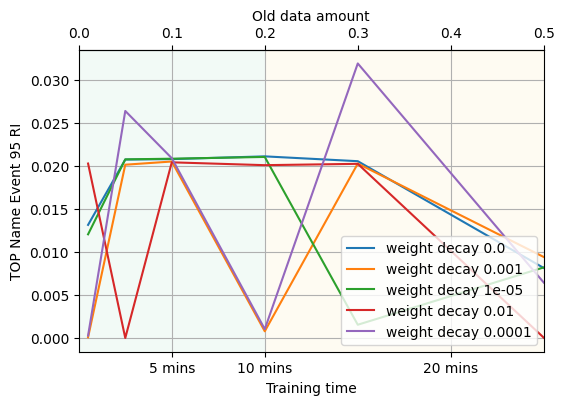

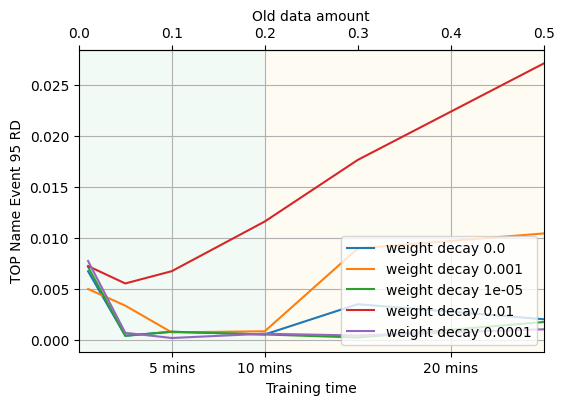

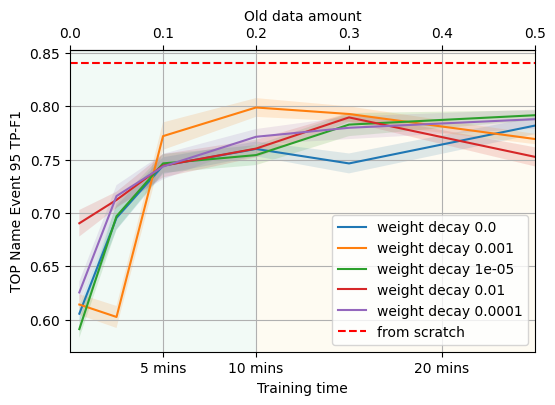

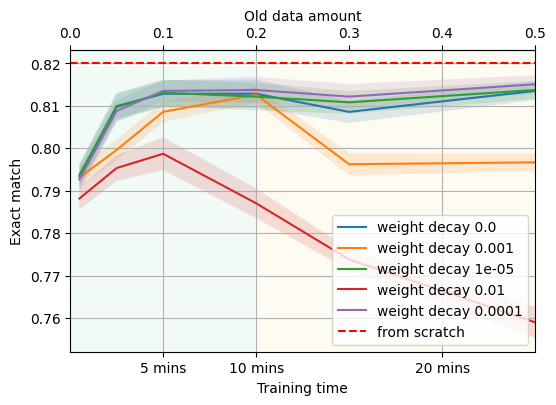

In [19]:
dataframe = pd.read_csv(StringIO(weight_decay_name_event_csv)).sort_values("old_data_amount")

wd_values = dataframe.weight_decay.unique()

dataframes = [
    dataframe[dataframe.weight_decay == d] for d in wd_values
]
labels = [f"weight decay {d}" for d in wd_values]

class_name = 'TOP Name Event 95'

plot(dataframes, labels, "relative_improvement", f"{class_name} RI", xlim=(0, 0.5))
plot(dataframes, labels, "relative_degradation", f"{class_name} RD", xlim=(0, 0.5))
plot(dataframes, labels, "cls/eval_NAME_EVENT_tree_path_f1", f"{class_name} TP-F1", initial=None, from_scratch=0.84, xlim=(0, 0.5))
plot(dataframes, labels, "eval_exact_match", "Exact match", initial=None, from_scratch=0.82, xlim=(0, 0.5))

# Move Norm (GetWeather 90)

In [20]:
move_norm_getweather90_csv = '''
"Name","old_data_amount","relative_improvement","move_norm","tags","freeze_encoder","_wandb","relative_improvement_0","cls/eval_GETWEATHER_tree_path_f1","cls/eval_GETWEATHER_tree_path_f1_std","eval_exact_match_std","eval_exact_match","relative_degradation","n_negative_outliers","n_positive_outliers","relative_degradation_0"
"prime-planet-3917 (move norm all)","0.5","0.004619430762438597","0.2","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.005593862810015216","0.9723995386164846","0.004594231581193803","0.0015971914124998442","0.9285714285714286","-0.00005356777700946999","1","12","-0.00035129228582821424"
"flowing-energy-3914 (move norm all)","0.2","0.0045150209097487735","0.2","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.005640753627322352","0.9723995386164846","0.004594231581193803","0.002766416675862431","0.9285714285714284","-0.00005356777700946999","1","11","-0.0002929564225186793"
"fallen-galaxy-3911 (move norm all)","0.1","0.003870091771657344","0.2","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.00456653100154029","0.9662434694540284","0.006510860756656884","0.00225876975726312","0.9285714285714286","-0.0001541376102111609","2","11","-0.0003511686249511185"
"whole-water-3908 (move norm all)","0.05","0.004056730292609935","0.2","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.004784239627131018","0.9642241701475894","0.006003399227480083","0.0029014422873700086","0.9257142857142856","-0.0001541376102111609","2","11","-0.0005584886447059273"
"vague-rain-3907 (move norm all)","0","0","0.2","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.0003580698750907522","0.8035656500408072","0.013395506423987168","0.004711037842240312","0.8728571428571428","-0.023434191957836643","18","0","-0.02387386566497709"
"revived-sky-3902 (move norm all)","0.5","0.004715848373091631","0.07","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.005190295338560444","0.9788113230825252","0.00331843676853123","0.001956151991089872","0.9285714285714284","-0.00005356777700946999","1","12","-0.0005090686622548651"
"zany-lion-3900 (move norm all)","0.2","0.004875343142166364","0.07","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.0054841191622581","0.9723995386164846","0.004594231581193803","0.0020824828195876","0.93","-0.00010056983320169088","1","12","-0.00041872372780612426"
"rural-sun-3898 (move norm all)","0.1","0.004347417955997385","0.07","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.0049327554546940745","0.9745779836403904","0.00391558422185395","0.002369017707396706","0.9271428571428572","-0.000026022016130636837","1","10","-0.0004589512612075226"
"easy-yogurt-3897 (move norm all)","0.05","0.004738412813479503","0.07","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.0053808741991724345","0.9684210695473512","0.00618227684099974","0.00262445329583911","0.93","-0.00010056983320169088","1","12","-0.00036175350955217447"
"lyric-water-3896 (move norm all)","0","0","0.07","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.0003580698750907522","0.7992085576606812","0.013423273209954048","0.004974424384708596","0.8699999999999999","-0.024569282286187967","18","0","-0.02506184035241236"
"fresh-snow-3895 (move norm all)","0.5","0","0.03","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.005791005820430405","0.9661227437860914","0.005236425733579648","0.001956151991089872","0.9285714285714284","0","0","13","-0.00010924146104212908"
"comic-bird-3894 (move norm all)","0.2","0.0027716220329110416","0.03","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.0040590452823639385","0.9642129124518992","0.006931545817572752","0.0030722590239437844","0.9271428571428572","-0.0004942859757969101","4","9","-0.000722992535670908"
"toasty-flower-3893 (move norm all)","0.1","0.00491089936626692","0.03","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.005409516987216739","0.9745779836403904","0.00391558422185395","0.0020824828195876","0.93","-0.000026022016130636837","1","11","-0.0004987624362804735"
"legendary-eon-3892 (move norm all)","0.05","0.004433669852436607","0.03","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.005026846377154034","0.9643437364631025","0.005226506778144267","0.0025253813613805177","0.9285714285714286","-0.00028091694704552065","3","13","-0.000587135315110867"
"copper-glade-3890 (move norm all)","0","0","0.03","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.0003580698750907522","0.7992085576606812","0.013423273209954048","0.004974424384708596","0.8699999999999999","-0.024569282286187967","18","0","-0.02506184035241236"
"devout-plasma-3889 (move norm all)","0.5","0","0.01","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.005661509352410136","0.9661227437860914","0.005236425733579648","0.0020824828195875997","0.9271428571428572","0","0","13","-0.00010924146104212908"
"jumping-paper-3888 (move norm all)","0.2","0.003853256203011796","0.01","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.00470965094497343","0.9723995386164846","0.004594231581193803","0.0018210783977117024","0.9257142857142856","-0.0002538228122739189","3","11","-0.0008475665260244101"
"sleek-mountain-3887 (move norm all)","0.1","0.004711626189366442","0.01","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.0051720699834138075","0.9745779836403904","0.00391558422185395","0.0029880715233359736","0.9285714285714284","-0.000026022016130636837","1","11","-0.0004456532225782313"
"lively-waterfall-3886 (move norm all)","0.05","0.0021349787884782116","0.01","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.003721164111582032","0.952390148383228","0.008219536854921543","0.0024222607082590155","0.9257142857142858","-0.0004794262748371083","3","10","-0.001010253134720074"
"comfy-dream-3885 (move norm all)","0","0","0.01","[""finetune"",""snips_get_weather_90_Aug19_bert_run_move_norm_all""]","None","","0.0003580698750907522","0.7992085576606812","0.013423273209954048","0.004974424384708596","0.8699999999999999","-0.024569282286187967","18","0","-0.02506184035241236"
'''

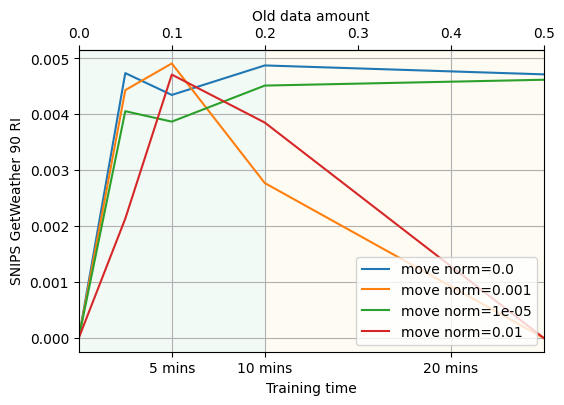

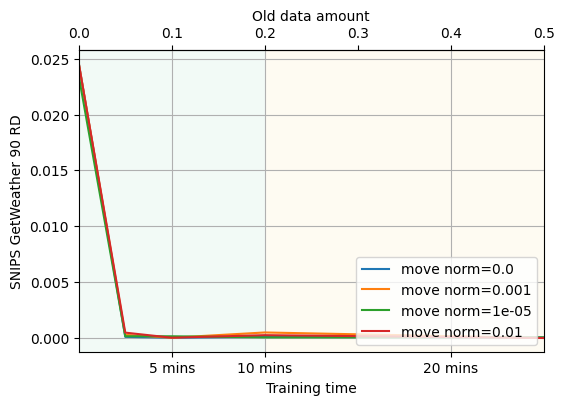

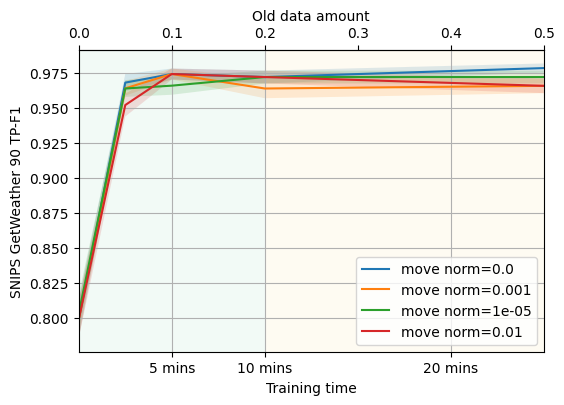

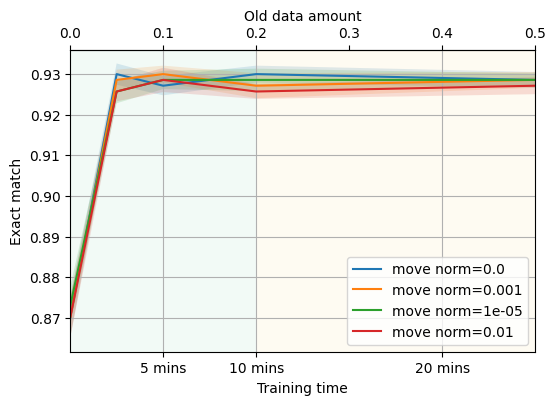

In [21]:
dataframe = pd.read_csv(StringIO(move_norm_getweather90_csv)).sort_values("old_data_amount")

_values = dataframe.move_norm.unique()

dataframes = [
    dataframe[dataframe.move_norm == d] for d in _values
]
labels = [f"move norm={d}" for d in wd_values]

class_name = 'SNIPS GetWeather 90'

plot(dataframes, labels, "relative_improvement", f"{class_name} RI", xlim=(0, 0.5))
plot(dataframes, labels, "relative_degradation", f"{class_name} RD", xlim=(0, 0.5))
plot(dataframes, labels, "cls/eval_GETWEATHER_tree_path_f1", f"{class_name} TP-F1", initial=None, from_scratch=None, xlim=(0, 0.5))
plot(dataframes, labels, "eval_exact_match", "Exact match", initial=None, from_scratch=None, xlim=(0, 0.5))

In [54]:
import torch

In [55]:
torch.__version__

'1.5.0'

# Move norm (NAME EVENT 95)

In [22]:
move_norm_nameevent95_csv = '''
"Name","old_data_amount","relative_improvement","dropout","tags","move_norm","weight_decay","_wandb","eval_exact_match","relative_degradation","cls/eval_NAME_EVENT_tree_path_f1_std","eval_exact_match_std","cls/eval_NAME_EVENT_tree_path_f1"
"kind-cloud-3510 (dynamic sampling)","1","0","0.2","[""finetune"",""name_event_95_Aug14_bert_run_sample""]","None","0","","0.8204842609689615","0","0.012727368589257344","0.003958950347460724","0.8361519029334818"
"fallen-energy-3505 (dynamic sampling)","0.5","0.003665939556851552","0.2","[""finetune"",""name_event_95_Aug14_bert_run_sample""]","None","0","","0.8182428621672884","-0.0001486779793768713","0.009254442705020302","0.002391678371089155","0.8518316912136876"
"treasured-moon-3500 (dynamic sampling)","0.2","0.017761916767052056","0.2","[""finetune"",""name_event_95_Aug14_bert_run_sample""]","None","0","","0.8200356420595144","-0.0005013528805308167","0.009747547010189504","0.002716098731720556","0.7989132091240199"
"faithful-snowflake-3495 (dynamic sampling)","0.15","0.00590887421169511","0.2","[""finetune"",""name_event_95_Aug14_bert_run_sample""]","None","0","","0.821156247252264","-0.00007692307692307693","0.010024258242170464","0.0030462678726338216","0.8370376209302599"
"usual-dew-3491 (dynamic sampling)","0.1","0.033503532316089005","0.2","[""finetune"",""name_event_95_Aug14_bert_run_sample""]","None","0","","0.8191391893080102","-0.00013089996376917034","0.00926104272759808","0.0024674830809472627","0.7903832369029058"
"wild-frost-3487 (dynamic sampling)","0.05","0.025313745814621043","0.2","[""finetune"",""name_event_95_Aug14_bert_run_sample""]","None","0","","0.8200361759053397","-0.0005271642161262463","0.010839383038640776","0.003068299290172262","0.7698759135046523"
"warm-rain-3483 (dynamic sampling)","0.01","0.02634849186493786","0.2","[""finetune"",""name_event_95_Aug14_bert_run_sample""]","None","0","","0.8059166760874753","-0.003301110643334164","0.008572791631200399","0.003217085618053995","0.7171362238580393"
"stilted-spaceship-4021 (move_norm)","0.05","0.02077082308000287","0","[""name_event_Aug19_move_norm""]","0","0","","0.8099509489894613","-0.0003983212637737055","0.011318897576051465","0.002940518585976079","0.695436135970139"
"fresh-silence-4081 (move_norm)","0.3","0.02057995464963844","0","[""name_event_Aug19_move_norm""]","0","0","","0.8086062227581616","-0.0034919526024695053","0.00932982349684874","0.0026080773988921353","0.7463833621827627"
"vital-dawn-4090 (move_norm)","0.5","0.01713433942701897","0","[""name_event_Aug19_move_norm""]","0.01","0","","0.8162261496526861","-0.00019071171818835372","0.006540853900446501","0.002377799490560041","0.8086964022492695"
"ancient-glade-4009 (move_norm)","0.05","0","0","[""name_event_Aug19_move_norm""]","0.2","0","","0.811519859064702","0","0.01128505296108333","0.003154627905393424","0.7513104927854108"
"iconic-terrain-4059 (move_norm)","0.2","0.02240913500475237","0","[""name_event_Aug19_move_norm""]","0.05","0","","0.8146572395774452","-0.00045846635077799046","0.0090057929562991","0.003237495179903026","0.7599129963642983"
"noble-wildflower-4047 (move_norm)","0.15","0.02674646770729987","0","[""name_event_Aug19_move_norm""]","0","0","","0.8103989084423008","-0.0016651638451789035","0.004509110154779411","0.0028208465100084557","0.7472819838886136"
"tough-hill-4037 (move_norm)","0.15","0.02154537487493416","0","[""name_event_Aug19_move_norm""]","0.2","0","","0.8117436974789916","-0.0009710929708742918","0.013188005170168889","0.002639192140346978","0.7856044687831668"
"vague-wave-4087 (move_norm)","0.5","0.021191859092282935","0","[""name_event_Aug19_move_norm""]","0.1","0","","0.8142091859165191","-0.000042692821197494103","0.008964132187165836","0.0027083811638416644","0.7842749592202397"
"zesty-shape-3991 (move_norm)","0","0","0","[""name_event_Aug19_move_norm""]","0.1","0","","0.7653516473854115","-0.01697753647444232","0.00983511850530793","0.0025161317908553474","0.5159470818747858"
"pleasant-glitter-4089 (move_norm)","0.5","0.00361824266635631","0","[""name_event_Aug19_move_norm""]","0.05","0","","0.8162261496526861","-0.00051078360891445","0.015306448054962842","0.0030946838772177654","0.8099882730456269"
"silvery-music-4031 (move_norm)","0.1","0.020576486924559656","0","[""name_event_Aug19_move_norm""]","0.01","0","","0.8115196392458328","-0.0012629176279878845","0.016569519385061095","0.0021960410771647626","0.6985172528282328"
"honest-microwave-4024 (move_norm)","0.1","0.0207773068292409","0","[""name_event_Aug19_move_norm""]","0.2","0","","0.8155539749532099","-0.00032307692307692305","0.015636615958214264","0.0029261054744375617","0.7617464665075616"
"stilted-sky-4028 (move_norm)","0.1","0.02110166111804368","0","[""name_event_Aug19_move_norm""]","0.05","0","","0.8144331185388953","-0.000042692821197494103","0.006022872345290679","0.0023032742944146083","0.7455786747457832"
"sandy-flower-4083 (move_norm)","0.5","0.004854595806215065","0","[""name_event_Aug19_move_norm""]","0.2","0","","0.8193638441923854","-0.00002599568655643422","0.012814886817202","0.004160818678761525","0.7786006874481164"
"dazzling-silence-4010 (move_norm)","0.05","0.013674351134746464","0","[""name_event_Aug19_move_norm""]","0.1","0","","0.8088303437967115","-0.0003897467926857388","0.01604527922808605","0.002415192101644401","0.686971824771326"
"crimson-lion-3994 (move_norm)","0","0","0","[""name_event_Aug19_move_norm""]","0.01","0","","0.7568354247528608","-0.02030417260983118","0.007876970420401955","0.002269221988913938","0.5231340909469676"
"tough-wildflower-4003 (move_norm)","0.01","0.0120788771595832","0","[""name_event_Aug19_move_norm""]","0.01","0","","0.7940387006820665","-0.00697624900221458","0.008556840662715755","0.002769225545283326","0.595097275712454"
"dry-yogurt-4000 (move_norm)","0.01","0.013478535832297248","0","[""name_event_Aug19_move_norm""]","0.05","0","","0.7985210272449788","-0.005591849235693441","0.007180059497559507","0.003309525777888111","0.6021424471996277"
"quiet-violet-4045 (move_norm)","0.15","0.026941547791550235","0","[""name_event_Aug19_move_norm""]","0.01","0","","0.8108475587544435","-0.0017593237763868488","0.01206441479013972","0.0036546061770748703","0.7941583987761602"
"desert-river-4055 (move_norm)","0.2","0.0008875169287662062","0","[""name_event_Aug19_move_norm""]","0.1","0","","0.8146572081747496","-0.000612251613522534","0.006003830330278409","0.0017477430507485197","0.788206336871288"
"atomic-terrain-4079 (move_norm)","0.3","0.02694003361082091","0","[""name_event_Aug19_move_norm""]","0.01","0","","0.8110714285714286","-0.000942748956068802","0.004478901492973667","0.002515594872298474","0.7811024787729324"
"clean-firebrand-4033 (move_norm)","0.1","0.02082168949878784","0","[""name_event_Aug19_move_norm""]","0","0","","0.8128643654771326","-0.0007875140814148946","0.00785567045992164","0.003133394091111336","0.7443153622165524"
"devout-monkey-4093 (move_norm)","0.5","0.008172516438055026","0","[""name_event_Aug19_move_norm""]","0","0","","0.813536602982","-0.002014891886916158","0.008045256569897158","0.002189100200048361","0.7818312251398657"
"peach-fog-4050 (move_norm)","0.2","0.02125289567509916","0","[""name_event_Aug19_move_norm""]","0.2","0","","0.8162264008742511","-0.00031108203512026386","0.0147576138333653","0.003670693099256779","0.7844955166241694"
"floral-monkey-3993 (move_norm)","0","0","0","[""name_event_Aug19_move_norm""]","0.05","0","","0.7577317832962781","-0.020382215962834384","0.00957493959854534","0.0022481046707193792","0.4898810155179883"
"divine-gorge-4027 (move_norm)","0.1","0.020644073141044123","0","[""name_event_Aug19_move_norm""]","0.1","0","","0.8128643654771326","-0.00040748159725167033","0.01430358674019858","0.00249176075862346","0.7180883873602248"
"morning-monkey-4075 (move_norm)","0.3","0.0193563899963344","0","[""name_event_Aug19_move_norm""]","0.05","0","","0.8146573337855323","-0.00044986753991616","0.009438594588406238","0.003222470406502121","0.7940677190614297"
"pious-glade-4019 (move_norm)","0.05","0.013693144530320871","0","[""name_event_Aug19_move_norm""]","0.01","0","","0.8099510746002437","-0.0007714083742897651","0.013249124939341527","0.003426202467249419","0.6901981832408688"
"happy-spaceship-3997 (move_norm)","0.01","0.013409897061501277","0","[""name_event_Aug19_move_norm""]","0.2","0","","0.8023310534976323","-0.002860837630418655","0.01123527287407702","0.002858247051287292","0.6549825345472543"
"deft-rain-3995 (move_norm)","0","0","0","[""name_event_Aug19_move_norm""]","0","0","","0.7566113037143107","-0.020456511204087837","0.007801259386612389","0.002293291185062504","0.5221339213603683"
"drawn-sky-4065 (move_norm)","0.2","0.02114083583888858","0","[""name_event_Aug19_move_norm""]","0","0","","0.8128643654771326","-0.0005215000467362683","0.0069723915904039415","0.0033276962981385054","0.7599463849965303"
"rose-surf-4068 (move_norm)","0.3","0.028351271973222687","0","[""name_event_Aug19_move_norm""]","0.2","0","","0.8182430819861576","-0.00033533221298035143","0.011761546652260944","0.0027199406831749607","0.7927773325401922"
"lunar-sea-3989 (move_norm)","0","0.014505494505494506","0","[""name_event_Aug19_move_norm""]","0.2","0","","0.7772298740123852","-0.00986648718947345","0.007635635699495762","0.0013981377571729312","0.5593159023245475"
"sage-lake-4014 (move_norm)","0.05","0.013691045228792978","0","[""name_event_Aug19_move_norm""]","0.05","0","","0.8108474645463566","-0.00026206964455102304","0.015629956702821614","0.0028765935895190167","0.7092863382446193"
"feasible-water-4041 (move_norm)","0.15","0.013662955471666653","0","[""name_event_Aug19_move_norm""]","0.1","0","","0.8108472761301829","-0.00018115435965903256","0.005916822583970967","0.0022816798463028347","0.7514387063926364"
"stoic-snowball-3998 (move_norm)","0.01","0.013547118401437","0","[""name_event_Aug19_move_norm""]","0.1","0","","0.800314026956074","-0.003983134183701053","0.007411620771837952","0.003256967885372366","0.6160786258801296"
"dutiful-lion-4070 (move_norm)","0.3","0.02325950778102274","0","[""name_event_Aug19_move_norm""]","0.1","0","","0.8119679755310196","-0.0005921125301714677","0.007333808998135434","0.0026891212883101384","0.779361672284284"
"curious-snowball-4043 (move_norm)","0.15","0.02681440086092423","0","[""name_event_Aug19_move_norm""]","0.05","0","","0.8110716169876022","-0.0019033081717848795","0.00949207627553883","0.003536157292083664","0.7952786723245248"
"efficient-star-4007 (move_norm)","0.01","0.0120788771595832","0","[""name_event_Aug19_move_norm""]","0","0","","0.7931421851251711","-0.007240532693661659","0.008190741300470896","0.0026648483276879046","0.5925074535346244"
"curious-wood-4062 (move_norm)","0.2","0.021203449359198087","0","[""name_event_Aug19_move_norm""]","0.01","0","","0.8130884551129869","-0.0005215000467362683","0.006735952653419889","0.0033591285067546247","0.7656499856924035"'''

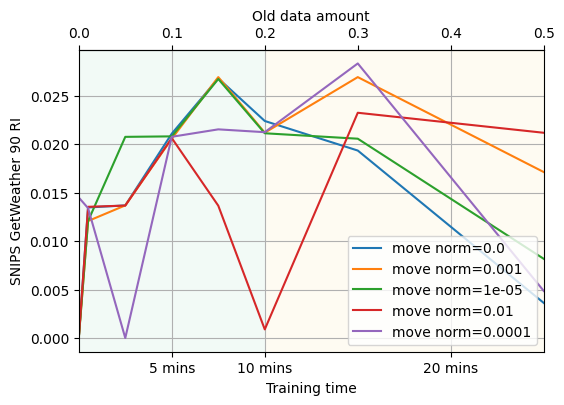

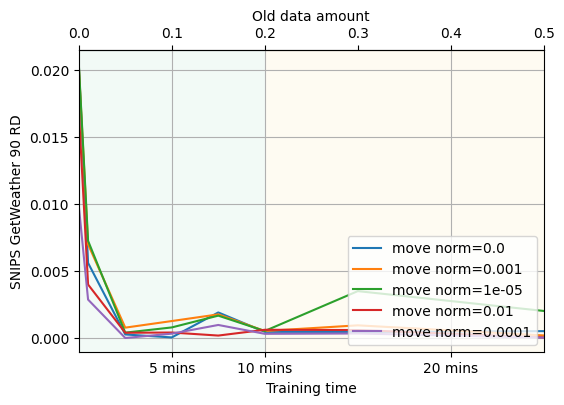

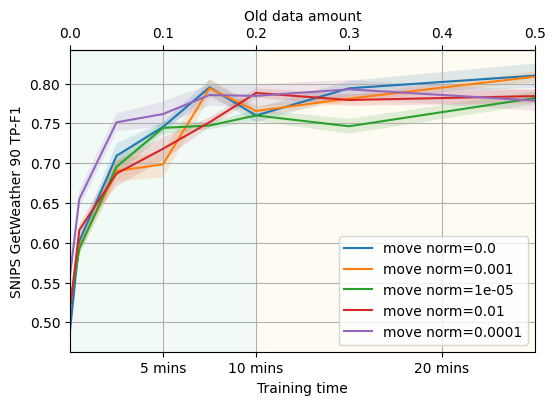

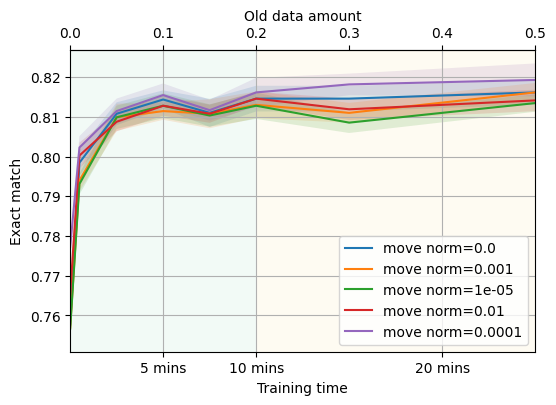

In [23]:
dataframe = pd.read_csv(StringIO(move_norm_nameevent95_csv)).sort_values("old_data_amount")

_values = dataframe.move_norm.unique()

dataframes = [
    dataframe[dataframe.move_norm == d] for d in _values
]
labels = [f"move norm={d}" for d in wd_values]

class_name = 'SNIPS GetWeather 90'

plot(dataframes, labels, "relative_improvement", f"{class_name} RI", xlim=(0, 0.5))
plot(dataframes, labels, "relative_degradation", f"{class_name} RD", xlim=(0, 0.5))
plot(dataframes, labels, "cls/eval_NAME_EVENT_tree_path_f1", f"{class_name} TP-F1", initial=None, from_scratch=None, xlim=(0, 0.5))
plot(dataframes, labels, "eval_exact_match", "Exact match", initial=None, from_scratch=None, xlim=(0, 0.5))

# IID train

In [24]:
iid_csv = """
Name	split_amount_train	eval_exact_match	Created	tags	eval_exact_match_std
clean-sunset-3182 (BERT)	0.9	8.16674E-01	2020-08-07T19:42:59.000Z	["train","iid_Aug6_bert"]	1.89495E-03
honest-music-3179 (BERT)	0.7	8.12864E-01	2020-08-07T18:40:51.000Z	["train","iid_Aug6_bert"]	2.59952E-03
floral-frog-3175 (BERT)	0.5	8.0121E-01	2020-08-07T17:10:00.000Z	["train","iid_Aug6_bert"]	1.99525E-03
sleek-sky-3171 (BERT)	0.3	7.81488E-01	2020-08-07T15:39:01.000Z	["train","iid_Aug6_bert"]	1.81941E-03
rural-wildflower-3170 (BERT)	0.15	7.5706E-01	2020-08-07T13:14:17.000Z	["train","iid_Aug6_bert"]	1.63813E-03
devout-field-3168 (BERT)	0.1	7.44285E-01	2020-08-07T10:38:20.000Z	["train","iid_Aug6_bert"]	2.13726E-03
denim-sun-3157 (BERT)	0.05	6.86464E-01	2020-08-07T07:15:06.000Z	["train","iid_Aug6_bert"]	1.77893E-03
silvery-tree-3128 (BERT)	0.01	9.61451E-02	2020-08-07T01:41:21.000Z	["train","iid_Aug6_bert"]	1.93909E-03
glorious-frog-2975 (noBERT)	0.1	5.51649E-01	2020-08-03T20:28:18.000Z	["train","iid_Aug3_nobert","iid_0.90"]	
electric-water-2974 (noBERT)	0.05	4.53993E-01	2020-08-03T19:24:42.000Z	["train","iid_Aug3_nobert","iid_0.95"]	
crisp-dawn-2973 (noBERT)	0.01	1.77951E-01	2020-08-03T16:48:31.000Z	["train","iid_Aug3_nobert","iid_0.99"]	
kind-fire-2875 (noBERT)	0.9	7.61393E-01	2020-07-31T21:21:38.000Z	["train","iid_Jul31_nobert","iid_0.1"]	
upbeat-frost-2874 (noBERT)	0.7	0.749023438	2020-07-31T20:27:15.000Z	["train","iid_Jul31_nobert","iid_0.3"]	
honest-bush-2873 (noBERT)	0.5	7.23307E-01	2020-07-31T19:42:06.000Z	["train","iid_Jul31_nobert","iid_0.5"]	
celestial-sound-2872 (noBERT)	0.3	0.655273438	2020-07-31T19:06:51.000Z	["train","iid_Jul31_nobert","iid_0.7"]	
"""

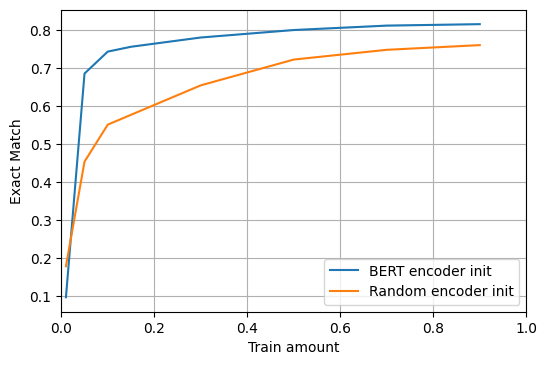

In [25]:
dataframe = pd.read_table(StringIO(iid_csv)).sort_values("split_amount_train")

bert_df = dataframe[dataframe.tags == '["train","iid_Aug6_bert"]']
nobert_df = dataframe[dataframe.tags.str.contains("nobert")]

dataframes = [bert_df, nobert_df]
labels = ["BERT encoder init", "Random encoder init"]

class_name = 'Exact Match'

plot(dataframes, labels, "eval_exact_match", class_name, xaxis="split_amount_train", xaxis_name="Train amount", no_time=True)

In [26]:
bert_df

,Name,split_amount_train,eval_exact_match,Created,tags,eval_exact_match_std
7,silvery-tree-3128 (BERT),0.01,0.096145,2020-08-07T01:41:21.000Z,"[""train"",""iid_Aug6_bert""]",0.001939
6,denim-sun-3157 (BERT),0.05,0.686464,2020-08-07T07:15:06.000Z,"[""train"",""iid_Aug6_bert""]",0.001779
5,devout-field-3168 (BERT),0.10,0.744285,2020-08-07T10:38:20.000Z,"[""train"",""iid_Aug6_bert""]",0.002137
4,rural-wildflower-3170 (BERT),0.15,0.757060,2020-08-07T13:14:17.000Z,"[""train"",""iid_Aug6_bert""]",0.001638
3,sleek-sky-3171 (BERT),0.30,0.781488,2020-08-07T15:39:01.000Z,"[""train"",""iid_Aug6_bert""]",0.001819
2,floral-frog-3175 (BERT),0.50,0.801210,2020-08-07T17:10:00.000Z,"[""train"",""iid_Aug6_bert""]",0.001995
1,honest-music-3179 (BERT),0.70,0.812864,2020-08-07T18:40:51.000Z,"[""train"",""iid_Aug6_bert""]",0.002600
0,clean-sunset-3182 (BERT),0.90,0.816674,2020-08-07T19:42:59.000Z,"[""train"",""iid_Aug6_bert""]",0.001895


# IID finetune

In [108]:
iid_finetune_csv = """
Name	old_data_amount	Created	split_amount_train	tags	relative_degradation	relative_improvement	eval_exact_match_std	eval_exact_match
olive-gorge-3258 (bert)	0.1	2020-08-09T16:29:35.000Z	0.9	["finetune","iid_Aug6_bert"]	-3.68826E-03	6.19442E-02	2.74485E-03	8.12416E-01
fanciful-breeze-3256 (bert)	0.01	2020-08-09T15:48:23.000Z	0.9	["finetune","iid_Aug6_bert"]	-8.77551E-04	3.56619E-02	1.82645E-03	8.11519E-01
zesty-lake-3254 (bert)	0	2020-08-09T15:13:46.000Z	0.9	["finetune","iid_Aug6_bert"]	-3.41015E-03	5.56992E-02	2.04697E-03	8.09951E-01
lemon-plant-3249 (bert)	0.1	2020-08-09T13:32:28.000Z	0.7	["finetune","iid_Aug6_bert"]	-2.55306E-04	7.20107E-03	2.8095E-03	8.18243E-01
dazzling-snowflake-3247 (bert)	0.01	2020-08-09T12:41:28.000Z	0.7	["finetune","iid_Aug6_bert"]	-9.77922E-04	2.18568E-02	1.83843E-03	8.13537E-01
bright-night-3245 (bert)	0	2020-08-09T11:54:33.000Z	0.7	["finetune","iid_Aug6_bert"]	-5.94704E-04	1.08541E-02	2.24745E-03	8.12864E-01
hearty-violet-3240 (bert)	0.1	2020-08-09T09:49:08.000Z	0.5	["finetune","iid_Aug6_bert"]	-4.47108E-05	1.30928E-02	2.40957E-03	8.19139E-01
absurd-morning-3238 (bert)	0.01	2020-08-09T08:46:40.000Z	0.5	["finetune","iid_Aug6_bert"]	-7.69231E-05	1.10167E-02	1.87894E-03	8.1645E-01
treasured-blaze-3236 (bert)	0	2020-08-09T07:46:16.000Z	0.5	["finetune","iid_Aug6_bert"]	-5.23958E-04	1.42094E-02	2.58817E-03	8.17122E-01
usual-pyramid-3231 (bert)	0.1	2020-08-09T05:08:30.000Z	0.3	["finetune","iid_Aug6_bert"]	-2.18676E-04	7.80701E-02	3.16703E-03	8.1914E-01
mild-shape-3229 (bert)	0.01	2020-08-09T03:55:27.000Z	0.3	["finetune","iid_Aug6_bert"]	-3.05919E-05	8.63472E-02	3.94776E-03	8.24294E-01
icy-serenity-3227 (bert)	0	2020-08-09T02:43:16.000Z	0.3	["finetune","iid_Aug6_bert"]	0	0	2.40473E-03	8.19363E-01
swift-brook-3222 (bert)	0.1	2020-08-08T23:40:16.000Z	0.15	["finetune","iid_Aug6_bert"]	-2.06742E-05	4.11628E-01	2.94054E-03	8.20932E-01
denim-dragon-3220 (bert)	0.01	2020-08-08T22:17:05.000Z	0.15	["finetune","iid_Aug6_bert"]	-3.23077E-04	4.42362E-01	3.12723E-03	8.2138E-01
balmy-pyramid-3218 (bert)	0	2020-08-08T20:54:38.000Z	0.15	["finetune","iid_Aug6_bert"]	0	0	2.54064E-03	8.20932E-01
astral-violet-3213 (bert)	0.1	2020-08-08T17:30:13.000Z	0.1	["finetune","iid_Aug6_bert"]	-2.07414E-05	2.26429E-01	2.22185E-03	8.22949E-01
lemon-microwave-3211 (bert)	0.01	2020-08-08T16:03:40.000Z	0.1	["finetune","iid_Aug6_bert"]	-1.56591E-05	2.81439E-01	2.34937E-03	8.22501E-01
playful-resonance-3209 (bert)	0	2020-08-08T14:36:58.000Z	0.1	["finetune","iid_Aug6_bert"]	-2.07601E-05	2.2116E-01	2.25309E-03	8.22277E-01
ethereal-butterfly-3204 (bert)	0.1	2020-08-08T11:03:49.000Z	0.05	["finetune","iid_Aug6_bert"]	0	0	3.70492E-03	8.22277E-01
neat-cloud-3202 (bert)	0.01	2020-08-08T09:32:01.000Z	0.05	["finetune","iid_Aug6_bert"]	0	0	3.55511E-03	8.22277E-01
crisp-firefly-3200 (bert)	0	2020-08-08T08:01:38.000Z	0.05	["finetune","iid_Aug6_bert"]	0	0	3.91885E-03	8.20036E-01
frosty-durian-3195 (bert)	0.1	2020-08-08T04:09:05.000Z	0.01	["finetune","iid_Aug6_bert"]	0	0	2.80851E-03	8.28552E-01
dry-dragon-3193 (bert)	0.01	2020-08-08T02:11:47.000Z	0.01	["finetune","iid_Aug6_bert"]	0	0	2.37593E-03	8.22725E-01
fragrant-oath-3191 (bert)	0	2020-08-08T00:28:04.000Z	0.01	["finetune","iid_Aug6_bert"]	0	0	2.8842E-03	8.22949E-01
distinctive-frost-2993 (nobert)	0.1	2020-08-04T03:02:35.000Z	0.1	["iid_Aug3_nobert","iid_0.90"]				7.30337E-01
fancy-glitter-2990 (nobert)	0.05	2020-08-04T02:20:31.000Z	0.1	["iid_Aug3_nobert","iid_0.90"]				7.32582E-01
soft-blaze-2988 (nobert)	0.01	2020-08-04T01:38:28.000Z	0.1	["iid_Aug3_nobert","iid_0.90"]				7.37536E-01
giddy-pond-2986 (nobert)	0.1	2020-08-04T00:54:52.000Z	0.05	["iid_Aug3_nobert","iid_0.95"]				7.24373E-01
valiant-leaf-2984 (nobert)	0.05	2020-08-04T00:11:19.000Z	0.05	["iid_Aug3_nobert","iid_0.95"]				7.28676E-01
sweet-pine-2982 (nobert)	0.01	2020-08-03T23:27:59.000Z	0.05	["iid_Aug3_nobert","iid_0.95"]				7.25204E-01
quiet-elevator-2980 (nobert)	0.1	2020-08-03T22:42:37.000Z	0.01	["iid_Aug3_nobert","iid_0.99"]				7.30346E-01
rose-lion-2978 (nobert)	0.05	2020-08-03T21:57:31.000Z	0.01	["iid_Aug3_nobert","iid_0.99"]				7.33309E-01
warm-cherry-2976 (nobert)	0.01	2020-08-03T21:12:29.000Z	0.01	["iid_Aug3_nobert","iid_0.99"]				7.28497E-01
"""


iid_finetune_csv2 = '''
"Name","old_data_amount","eval_exact_match","dropout","tags","split_amount_train","_wandb","eval_exact_match_std","relative_degradation","relative_improvement"
"crisp-cosmos-4222 (bert (more))","0.2","0.8186913554659532","0.2","[""finetune"",""iid_Aug21_bert""]","0.30000000000000004","","0.0024175727176828496","-0.0000822974418711237","0.1856082743906718"
"wobbly-sound-4220 (bert (more))","0.1","0.8216043009131904","0.2","[""finetune"",""iid_Aug21_bert""]","0.09999999999999998","","0.0022515219755124927","0","0"
"visionary-energy-4217 (bert (more))","0.15","0.8220532338495936","0.2","[""finetune"",""iid_Aug21_bert""]","0.30000000000000004","","0.002864994147161723","-0.000045976471175153","0.11000148319081755"
"stoic-serenity-4215 (bert (more))","0.05","0.821156247252264","0.2","[""finetune"",""iid_Aug21_bert""]","0.09999999999999998","","0.001357010879257722","0","0"
"feasible-serenity-4213 (bert (more))","0.1","0.8200361130999484","0.2","[""finetune"",""iid_Aug21_bert""]","0.30000000000000004","","0.0031023736983190964","-0.00019136303336729697","0.08983367086200623"
"sage-monkey-4207 (bert (more))","0.01","0.8209323460325834","0.2","[""finetune"",""iid_Aug21_bert""]","0.09999999999999998","","0.002409758254655024","0","0"
"neat-jazz-4202 (bert (more))","0.05","0.8189155079071988","0.2","[""finetune"",""iid_Aug21_bert""]","0.30000000000000004","","0.002964431250430166","-0.000077659759901","0.24745041652600008"
"vital-dawn-4189 (bert (more))","0","0.8211565612792201","0.2","[""finetune"",""iid_Aug21_bert""]","0.09999999999999998","","0.0026989015227443696","0","0"
"lemon-star-4186 (bert (more))","0.01","0.8249668387534385","0.2","[""finetune"",""iid_Aug21_bert""]","0.30000000000000004","","0.003947041033382647","-0.000030591855790537616","0.1079271677054581"
"dashing-sound-4179 (bert (more))","0","0.8202599201115424","0.2","[""finetune"",""iid_Aug21_bert""]","0.30000000000000004","","0.0022973051473596704","0","0"
'''

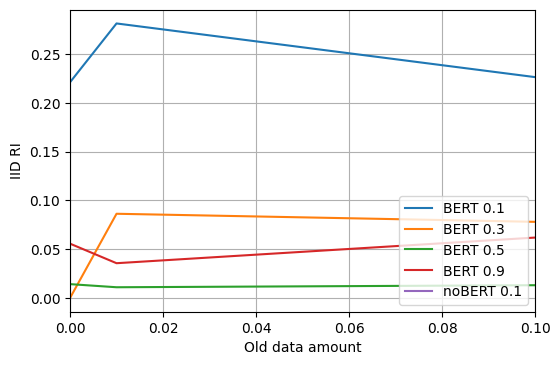

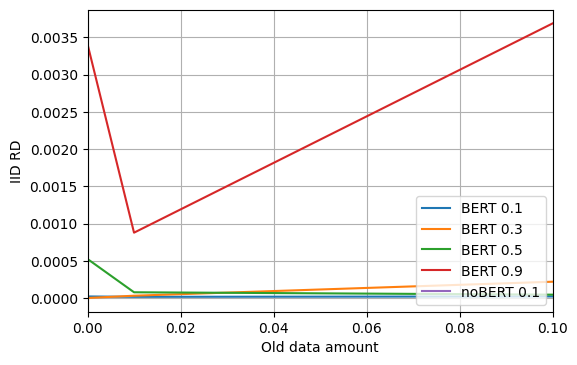

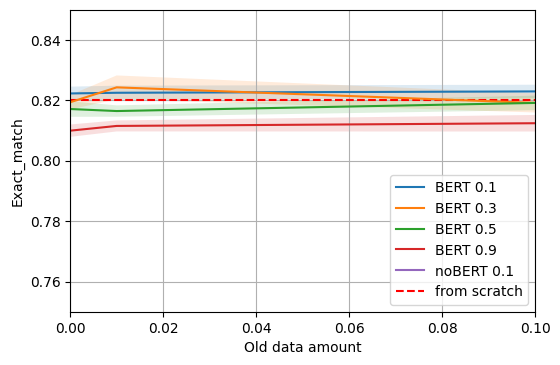

In [118]:
if True:
    dataframe = pd.read_table(StringIO(iid_finetune_csv)).sort_values("old_data_amount")
    bert_df = dataframe[dataframe.tags.str.contains("iid_Aug6_bert")]
    nobert_df = dataframe[dataframe.tags.str.contains("nobert")]

    splits = [0.1, 0.3, 0.5, 0.9]
    berts = [
        bert_df[bert_df.split_amount_train == s] for s in splits
    ]

    noberts = [
        nobert_df[nobert_df.split_amount_train == s] for s in splits
    ]


    dataframes = [*berts, *noberts]
    labels = [*[f"BERT {s}" for s in splits], *[f"noBERT {s}" for s in splits[:1]]]

else:
    dataframe = pd.read_csv(StringIO(iid_finetune_csv2)).sort_values("old_data_amount")
    _values = dataframe.split_amount_train.unique()

    dataframes = [
        dataframe[dataframe.split_amount_train == d] for d in _values
    ]
    labels = [f"train amount {round(d, 1)}" for d in _values]


class_name = 'Exact Match'

# with plt.style.context('seaborn-whitegrid'):

plot(dataframes, labels, "relative_improvement", "IID RI", xlim=(0, 0.1), no_time=True)
plot(dataframes, labels, "relative_degradation", "IID RD", xlim=(0, 0.1), no_time=True)
plot(dataframes, labels, "eval_exact_match", "Exact_match", initial=None, from_scratch=0.82, ylim=(0.75, 0.85), xlim=(0, 0.1), no_time=True)

# New data

In [87]:
new_data_path99_csv = '''
"Name","new_data_amount","eval_exact_match","old_data_amount","_wandb","relative_improvement","eval_exact_match_std","relative_degradation","cls/eval_PATH_tree_path_f1_std","cls/eval_PATH_tree_path_f1"
"logical-energy-4139 (old=0.2)","1","0.8218290814083481","0.2","","0.3838646154869562","0.0025398627836686173","-0.0004044534049844785","0.014651703284489313","0.6062921085733671"
"grateful-spaceship-4134 (old=0.2)","0.9","0.8175703420381606","0.2","","0.3255671292505483","0.0031057636111587383","-0.0003987666837736073","0.012625486901436365","0.5983754181692376"
"ethereal-vortex-4129 (old=0.2)","0.8","0.8193633731519514","0.2","","0.4408580884456846","0.0012142894535267694","-0.0006132377463629181","0.013572352957359236","0.6355284012354067"
"zany-planet-4125 (old=0.2)","0.7","0.8189151310748514","0.2","","0.4172730199634994","0.003039347871804671","-0.0004633922255264308","0.014148761753844169","0.6395349972177949"
"olive-thunder-4122 (old=0.2)","0.6","0.8184667947896648","0.2","","0.38048087396228647","0.002103608179883828","-0.00021353466677207685","0.0224837110903432","0.6120599575872919"
"warm-shadow-4118 (old=0.2)","0.5","0.8189147542425042","0.2","","0.399835545542696","0.003256171695619615","-0.0005844228979554805","0.014172895665720263","0.6329012590020032"
"wise-field-4116 (old=0.2)","0.4","0.8160017145871802","0.2","","0.3187642372506788","0.0013523030793989369","-0.00047600827066224185","0.013270398061882","0.5650670614934781"
"solar-forest-4114 (old=0.2)","0.3","0.8146571139666628","0.2","","0.4125978784131441","0.0007396783438022011","-0.00036060708552406026","0.009680403508242848","0.6164058138840913"
"super-sponge-4112 (old=0.2)","0.2","0.8166741091055256","0.2","","0.3454730535336979","0.0013593282188784782","-0.0008110099159164835","0.01092460571422429","0.5703739686197264"
"vital-paper-4109 (old=0.2)","0.1","0.8151051676275891","0.2","","0.3725621828557892","0.0037326204112257673","-0.0003379166854360785","0.014009614276276948","0.5459902632465956"
"fancy-shape-4152 (old=0)","1","0.716943544233837","0","","0.29532510921181593","0.003257669611942154","-0.02487534276788147","0.012311770311630678","0.28247088644426566"
"resilient-plant-4151 (old=0)","0.9","0.7023757395334815","0","","0.27818122982212473","0.001909133769746661","-0.03134219864505663","0.007074137991891318","0.27191935957043734"
"rural-donkey-4150 (old=0)","0.8","0.7061857343834396","0","","0.3721792625215193","0.002104726958511633","-0.029021176537246778","0.004963815113010541","0.29081426641345665"
"lucky-terrain-4148 (old=0)","0.7","0.6934111806157441","0","","0.24632083660750984","0.001784406045890677","-0.03617916836409365","0.005092603907750148","0.24279683172693747"
"celestial-shadow-4147 (old=0)","0.6","0.708202823730389","0","","0.30322505597912086","0.0023121001342369723","-0.031074323299257123","0.005105072512739042","0.2604318078423292"
"revived-wildflower-4146 (old=0)","0.5","0.7548185552247805","0","","0.0021029750955052673","0.003365690190000916","-0.0222559890448928","0.00816167196718369","0.2306270321914448"
"balmy-lion-4144 (old=0)","0.4","0.7808160304480537","0","","0.0035493219465487645","0.0029539851703739677","-0.009996223819797067","0.01301710630435964","0.32049123535328106"
"light-fire-4143 (old=0)","0.3","0.7830569896119883","0","","0.010777780198097858","0.0026075187103626707","-0.007398299382268738","0.017143335938416843","0.3399811129280429"
"skilled-sponge-4142 (old=0)","0.2","0.785522132619864","0","","0.00907685345404142","0.0027631933329232477","-0.007562492891233371","0.021944305463473195","0.2997894054708214"
"restful-waterfall-4140 (old=0)","0.1","0.7974000138171861","0","","0.008067078022216703","0.002643540918853475","-0.0028671043285406505","0.01776655152769824","0.2402522896787401"
"splendid-feather-4216 (others)","0.7","0.8095373511314392","0.05","","","0.002749453256653696","","0.01456803933733232","0.12787073244076674"
"solar-snowflake-4214 (others)","0.6","0.8157774051324566","0.05","","0.3566857291402332","0.004085380622987292","-0.0004111403498970607","0.016070736254760125","0.583765197116899"
"exalted-lion-4212 (others)","0.5","0.81331248194345","0.05","","0.3672064743141289","0.002335282131577571","-0.0001496453463253421","0.012757684450560794","0.5968556586320914"
"vital-night-4211 (others)","0.4","0.8110709261282988","0.05","","0.2950100379749254","0.0023947796878407927","-0.0003152442768872728","0.017256119310433377","0.5294422301862685"
"northern-yogurt-4206 (others)","0.3","0.8184673914408812","0.05","","0.3713530026089898","0.003238285722972852","-0.00004615384615384615","0.01212288977712314","0.6052854508694115"
"polished-butterfly-4198 (others)","0.2","0.8139846252402305","0.05","","0.37242167121308334","0.004601189170483285","-0.00006063100343519656","0.00856382119621009","0.5619573345625166"
"valiant-dragon-4194 (others)","0.1","0.815105575862632","0.05","","0.4175386095301351","0.00409818246957139","-0.0000923076923076923","0.01727719727040763","0.5696990410684245"
"fresh-silence-4188 (others)","1","0.8036754028965847","0.01","","0.359478884793078","0.0010227587142443114","-0.0005729477789156379","0.02808039738311596","0.5119954449147462"
"lucky-wildflower-4184 (others)","0.9","0.7906766966876436","0.01","","0.3286922510130971","0.002762027190286176","-0.004457160666673723","0.013159183197649034","0.4504613200410823"
"stilted-disco-4180 (others)","0.8","0.8041238019871626","0.01","","0.3981086515940556","0.0022423836205140955","-0.0003919330698539876","0.014950473800061264","0.5445998202593223"
"fearless-monkey-4178 (others)","0.7","0.7958312607554233","0.01","","0.34483841197453763","0.0020585645014690227","-0.0012064214779730837","0.01603883681259829","0.4773408417798596"
"exalted-field-4177 (others)","0.6","0.7985206504126314","0.01","","0.34988129090600295","0.0029740625061204637","-0.0015959654394077764","0.009622543257967657","0.470409219144325"
"dutiful-durian-4176 (others)","0.5","0.7978484129077641","0.01","","0.30599809738706163","0.0026374590357672086","-0.0009610309243073208","0.006715562733232002","0.4627502796421933"
"smart-sponge-4175 (others)","0.4","0.798744645840399","0.01","","0.2872007044484804","0.0029885951949444596","-0.0010405256897794218","0.01000119063382766","0.4587195459316692"
"colorful-fire-4174 (others)","0.3","0.8108472447274874","0.01","","0.3692016441991322","0.0034997256473514315","-0.0005463098832174944","0.011491333895752666","0.5104565749354772"
"robust-galaxy-4170 (others)","0.2","0.8121920965695695","0.01","","0.3984113522923758","0.0025766534778528835","-0.00020378385125476944","0.009159644228053454","0.5807853935414172"
"dashing-frost-4169 (others)","0.1","0.799641506826946","0.01","","0.30706060854471773","0.002944171255261059","-0.0010334452085449225","0.014027765928242548","0.4833887140792991"
'''

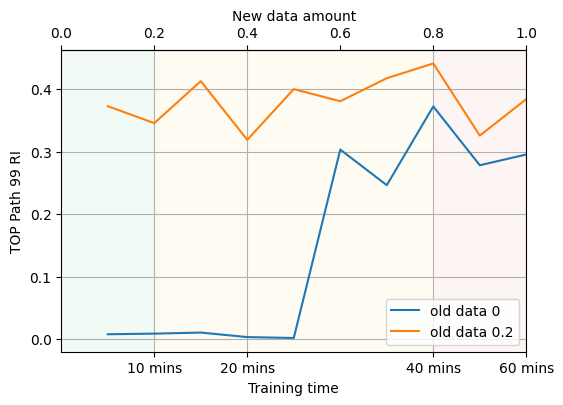

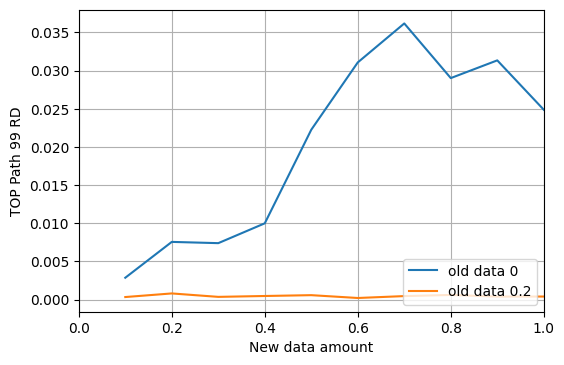

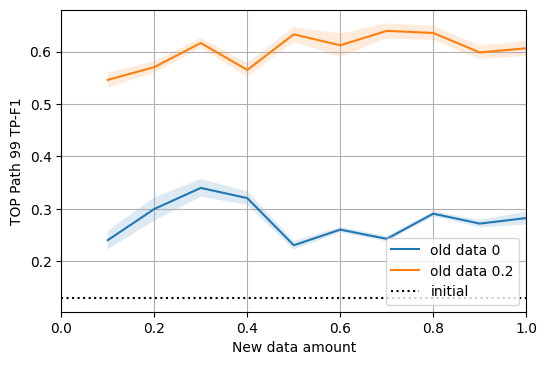

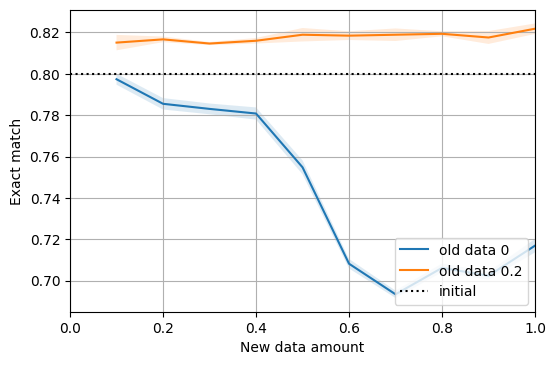

In [97]:
_xaxis = "new_data_amount"
_xaxis_name = "New data amount"

dataframe = pd.read_csv(StringIO(new_data_path99_csv)).sort_values(_xaxis)

_values = [0, 0.2]

dataframes = [
    dataframe[dataframe.old_data_amount == d] for d in _values
]
labels = [f"old data {d}" for d in _values]

class_name = 'TOP Path 99'

plot(dataframes, labels, "relative_improvement", f"{class_name} RI", xaxis_name=_xaxis_name, xaxis=_xaxis)
plot(dataframes, labels, "relative_degradation", f"{class_name} RD", xaxis_name=_xaxis_name, xaxis=_xaxis, no_time=True)
plot(dataframes, labels, "cls/eval_PATH_tree_path_f1", f"{class_name} TP-F1", initial=0.13, from_scratch=None, xaxis_name=_xaxis_name, xaxis=_xaxis, no_time=True)
plot(dataframes, labels, "eval_exact_match", "Exact match", initial=0.8, from_scratch=None, xaxis_name=_xaxis_name, xaxis=_xaxis, no_time=True)